In [1]:
import pickle
from typing import *
from pathlib import Path
from PIL import Image
import numpy as np
import cv2

def load_pkl(fp: Union[Path, str]) -> Any:
    """
    Загрузить pickle файл

    Parameters
    ----------
    fp: Union[Path, str]
        Путь к pickle файлу

    Returns
    -------
    obj: Any
        Загруженный объект
    """
    with open(fp, 'rb+') as f:
        obj = pickle.load(f)
    return obj

def dump_pkl(obj: Any, fp: Union[Path, str]) -> None:
    """
    Сохранить объект в  pickle файл

    Parameters
    ----------
    obj: Any
        Объект который нужно сохранить
    fp: Union[Path, str]
        Путь к pickle файлу
    """
    with open(fp, 'wb+') as f:
        pickle.dump(obj, f)

In [3]:
damage_masks = []
for mask in load_pkl('/Users/user/Downloads/masks_list.pkl'):
    mask[mask != 0] = 255
    damage_masks.append(mask)

damage_matrix = damage_masks[0]

In [7]:
np.unique(damage_matrix)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

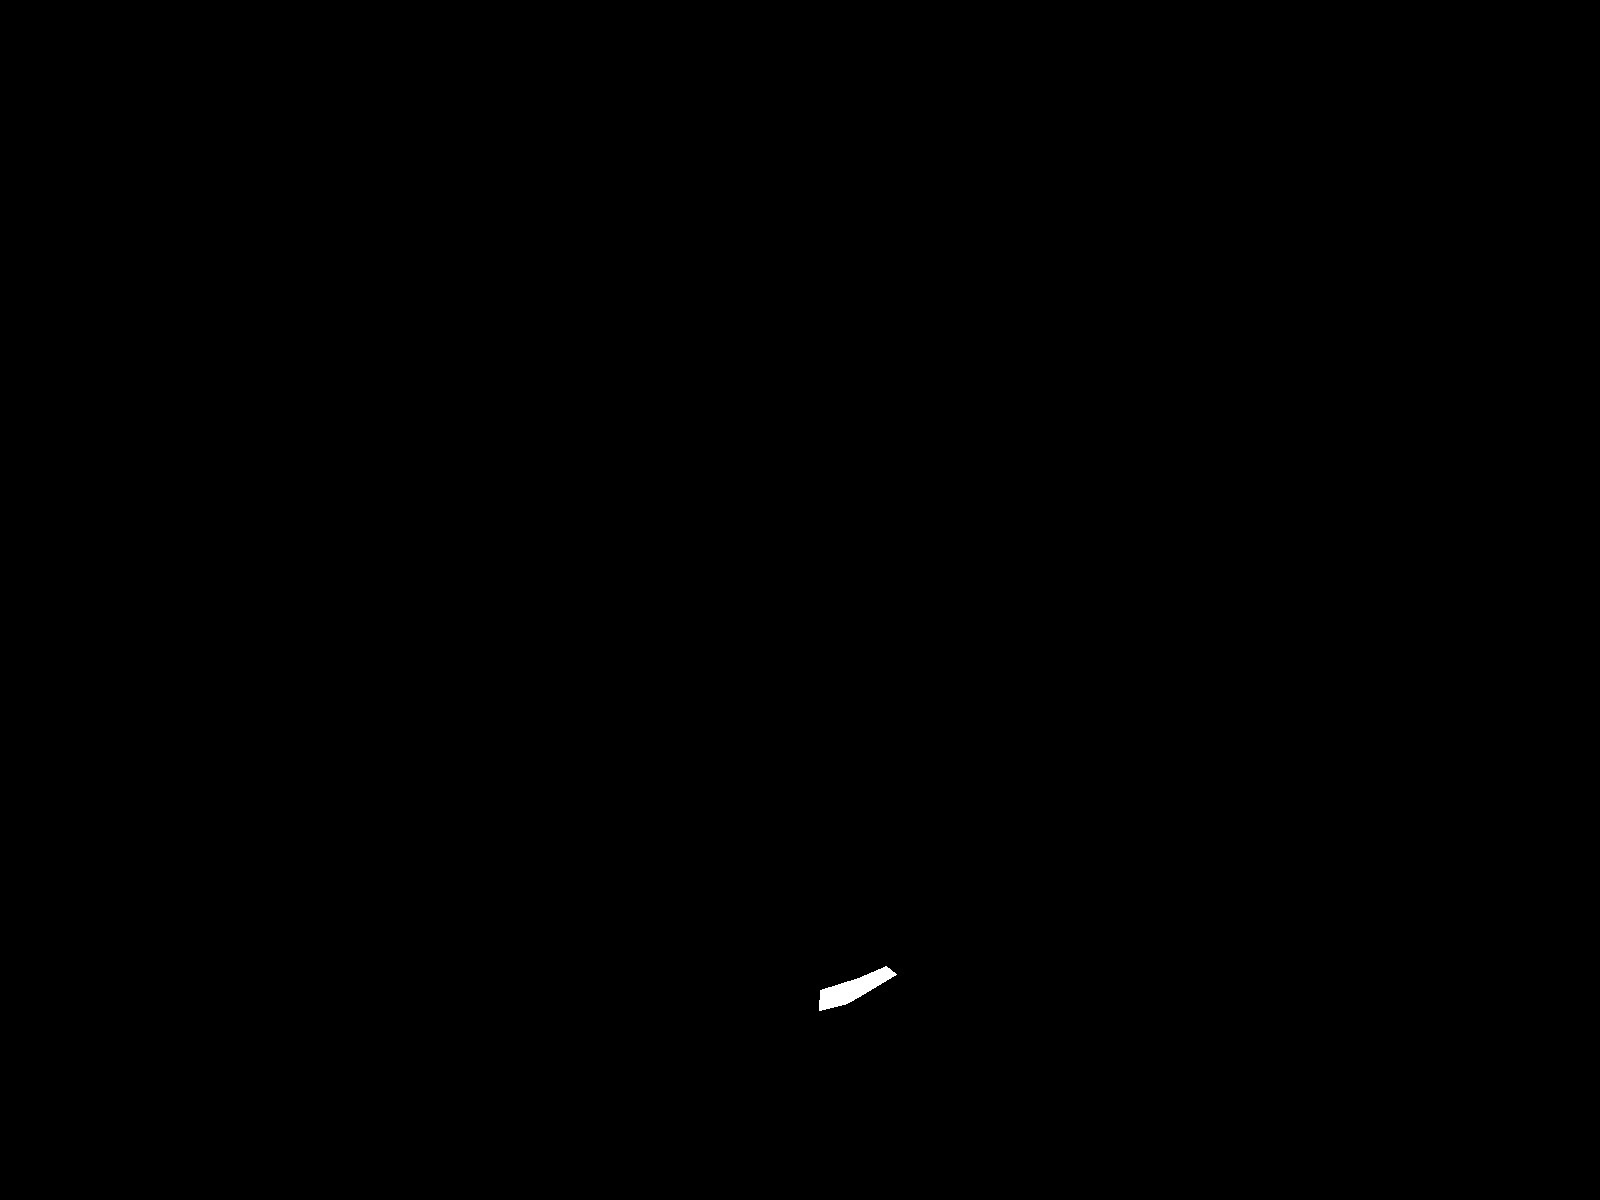

In [35]:
Image.fromarray(damage_matrix.astype('uint8'))

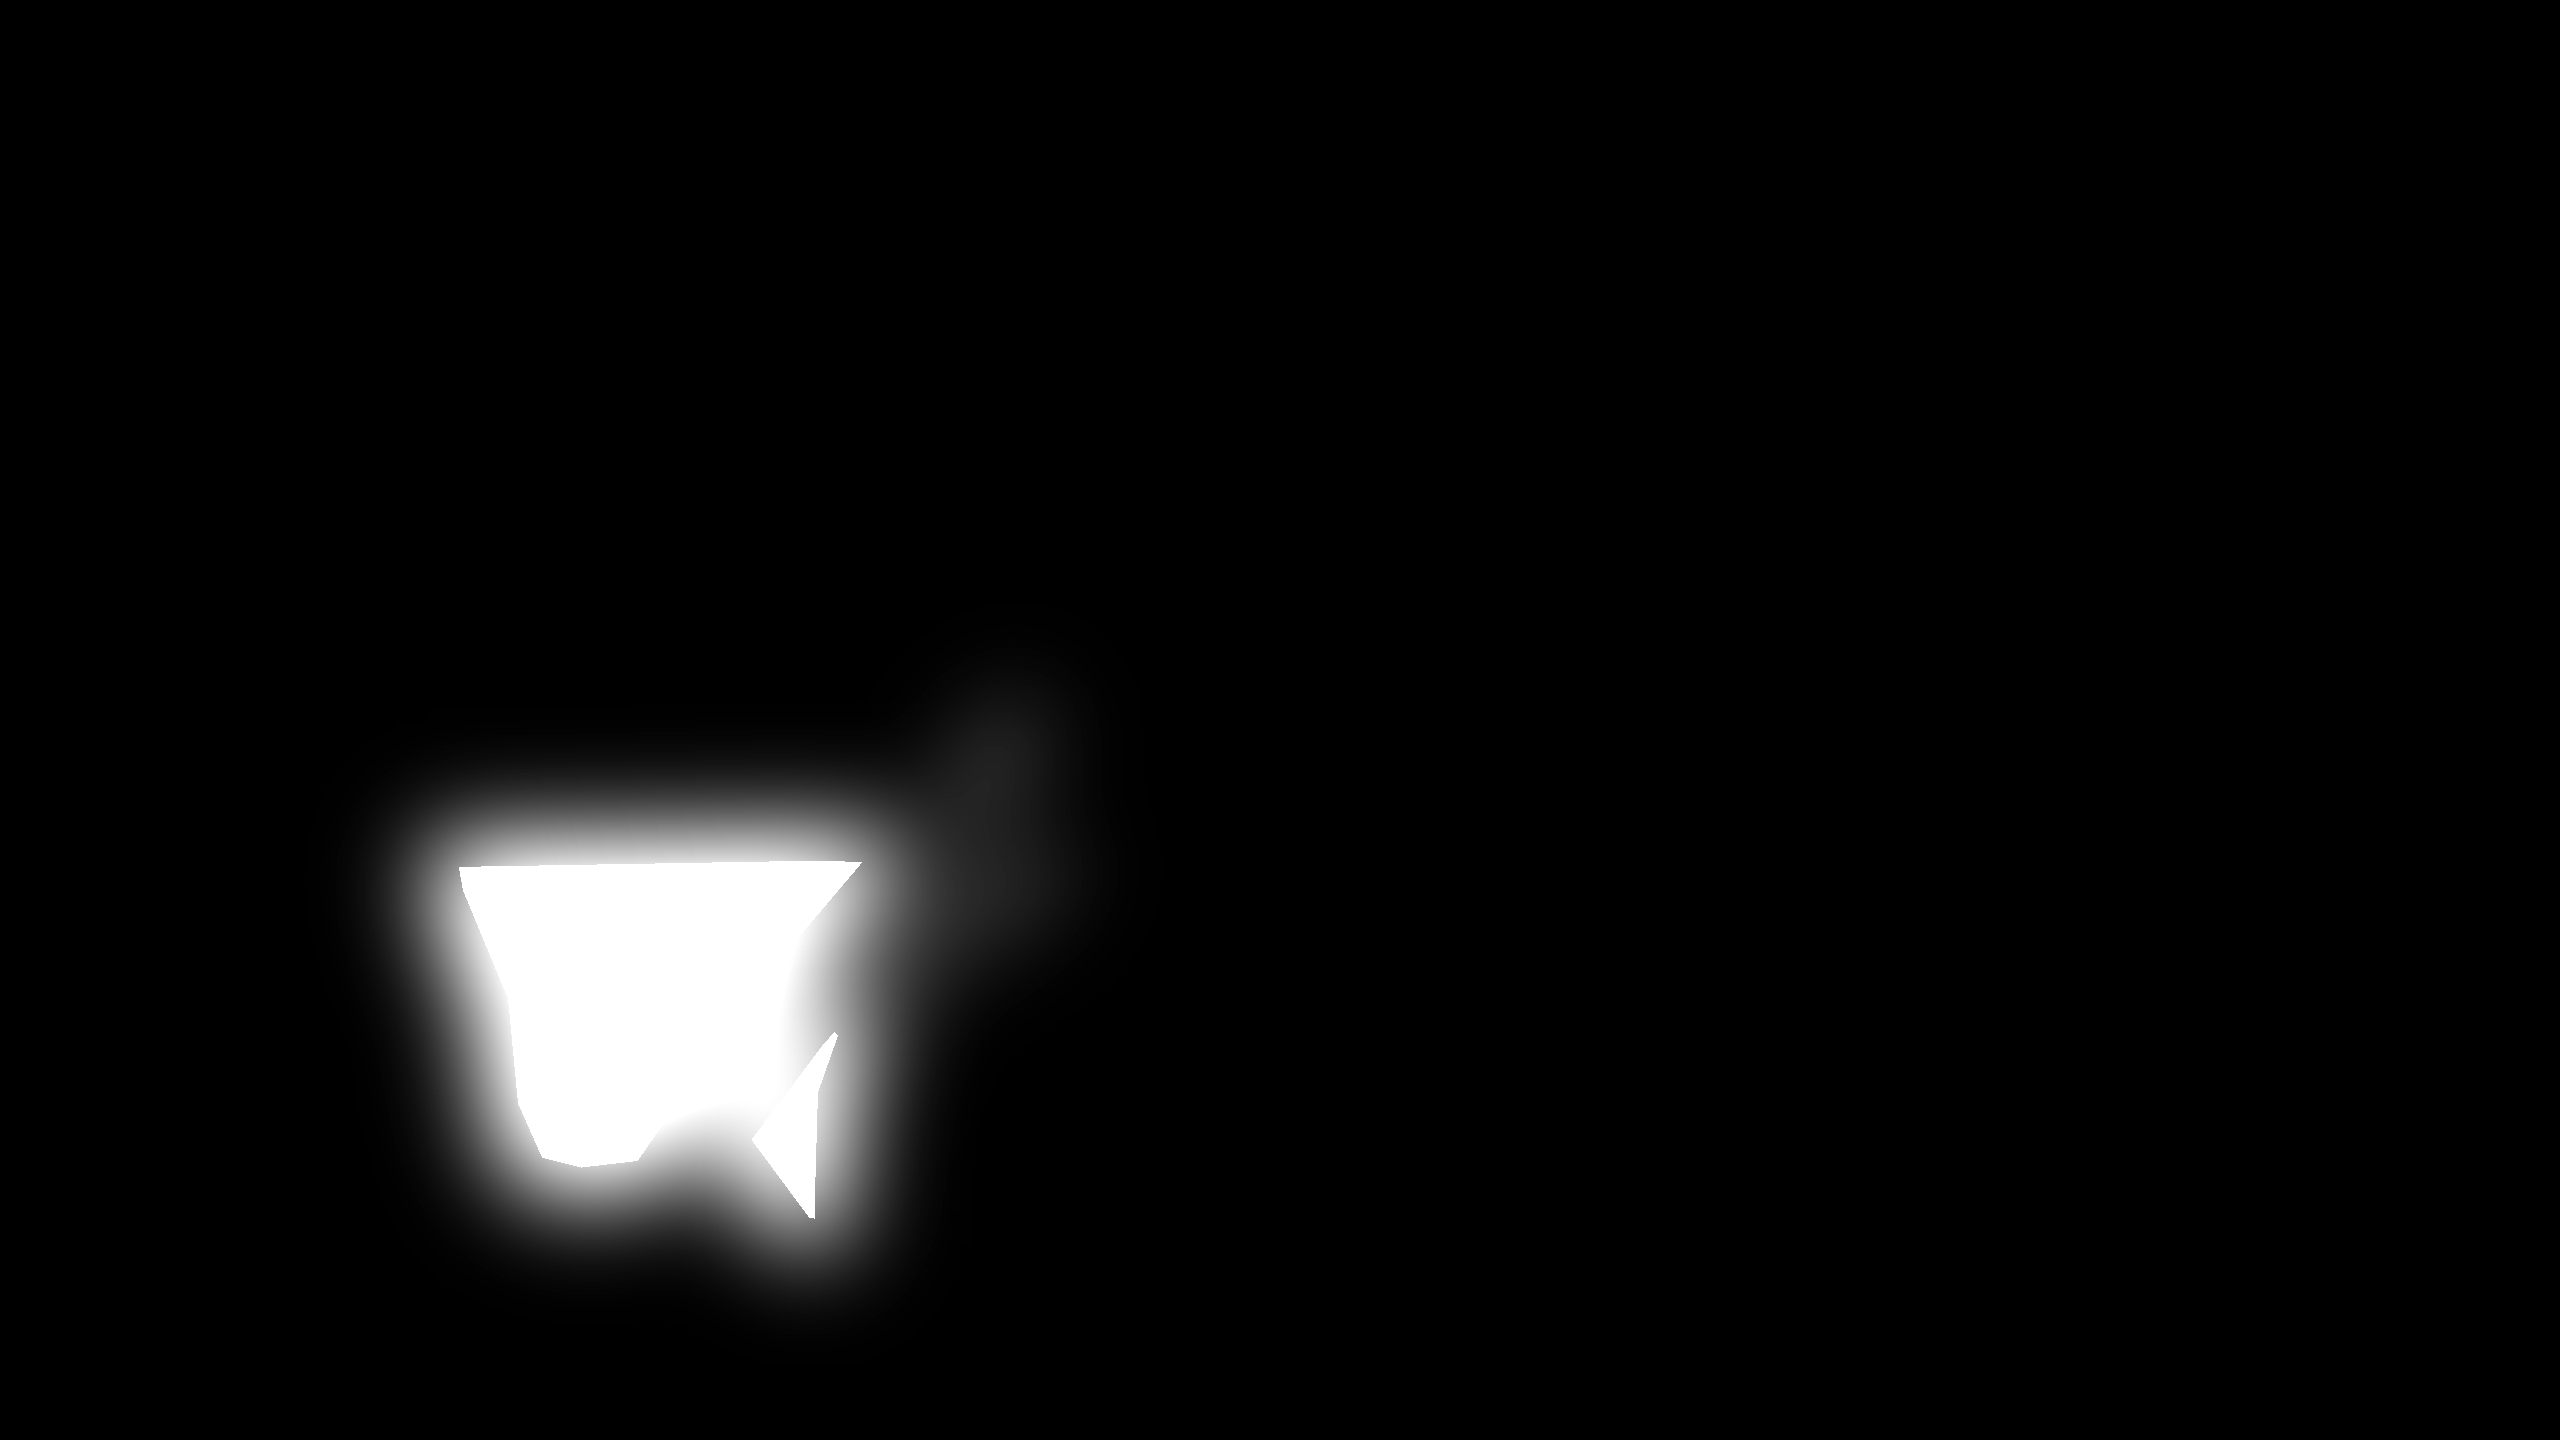

In [59]:
from skimage.morphology import dilation, erosion

def multi_morph(im, num, element, type='dilation'):

    morph_func = {
        'dilation': dilation,
        'erosion': erosion,
    }

    for _ in range(num):
        im = morph_func[type](im, element)
    return im


def transform(mask):

    mask = mask.copy()

    area_norm = 30_000_000
    area = mask.sum()
    area_normed = np.log(1 + area / area_norm)

    element = np.ones((5, 5))

    blur_value = 50

    iter_num = 10

    erod_iter_num = int(15 * area_normed)
    erod_iter_num = max(1, erod_iter_num)

    mask_kernel = cv2.morphologyEx(mask, cv2.MORPH_ERODE, element, iterations=erod_iter_num)
    #mask_kernel = multi_morph(mask, 7, element, type='erosion')
    #mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, element, iterations=iter_num)
    mask = cv2.GaussianBlur(mask, (0,0), sigmaX=blur_value, sigmaY=blur_value)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, element, iterations=7)
    mask = mask * 1.3

    mask[(mask_kernel > 240) | (mask > 255)] = 255

    return mask

Image.fromarray(transform(damage_matrix).astype('uint8'))

In [62]:
damage_matrix.sum()

1100580

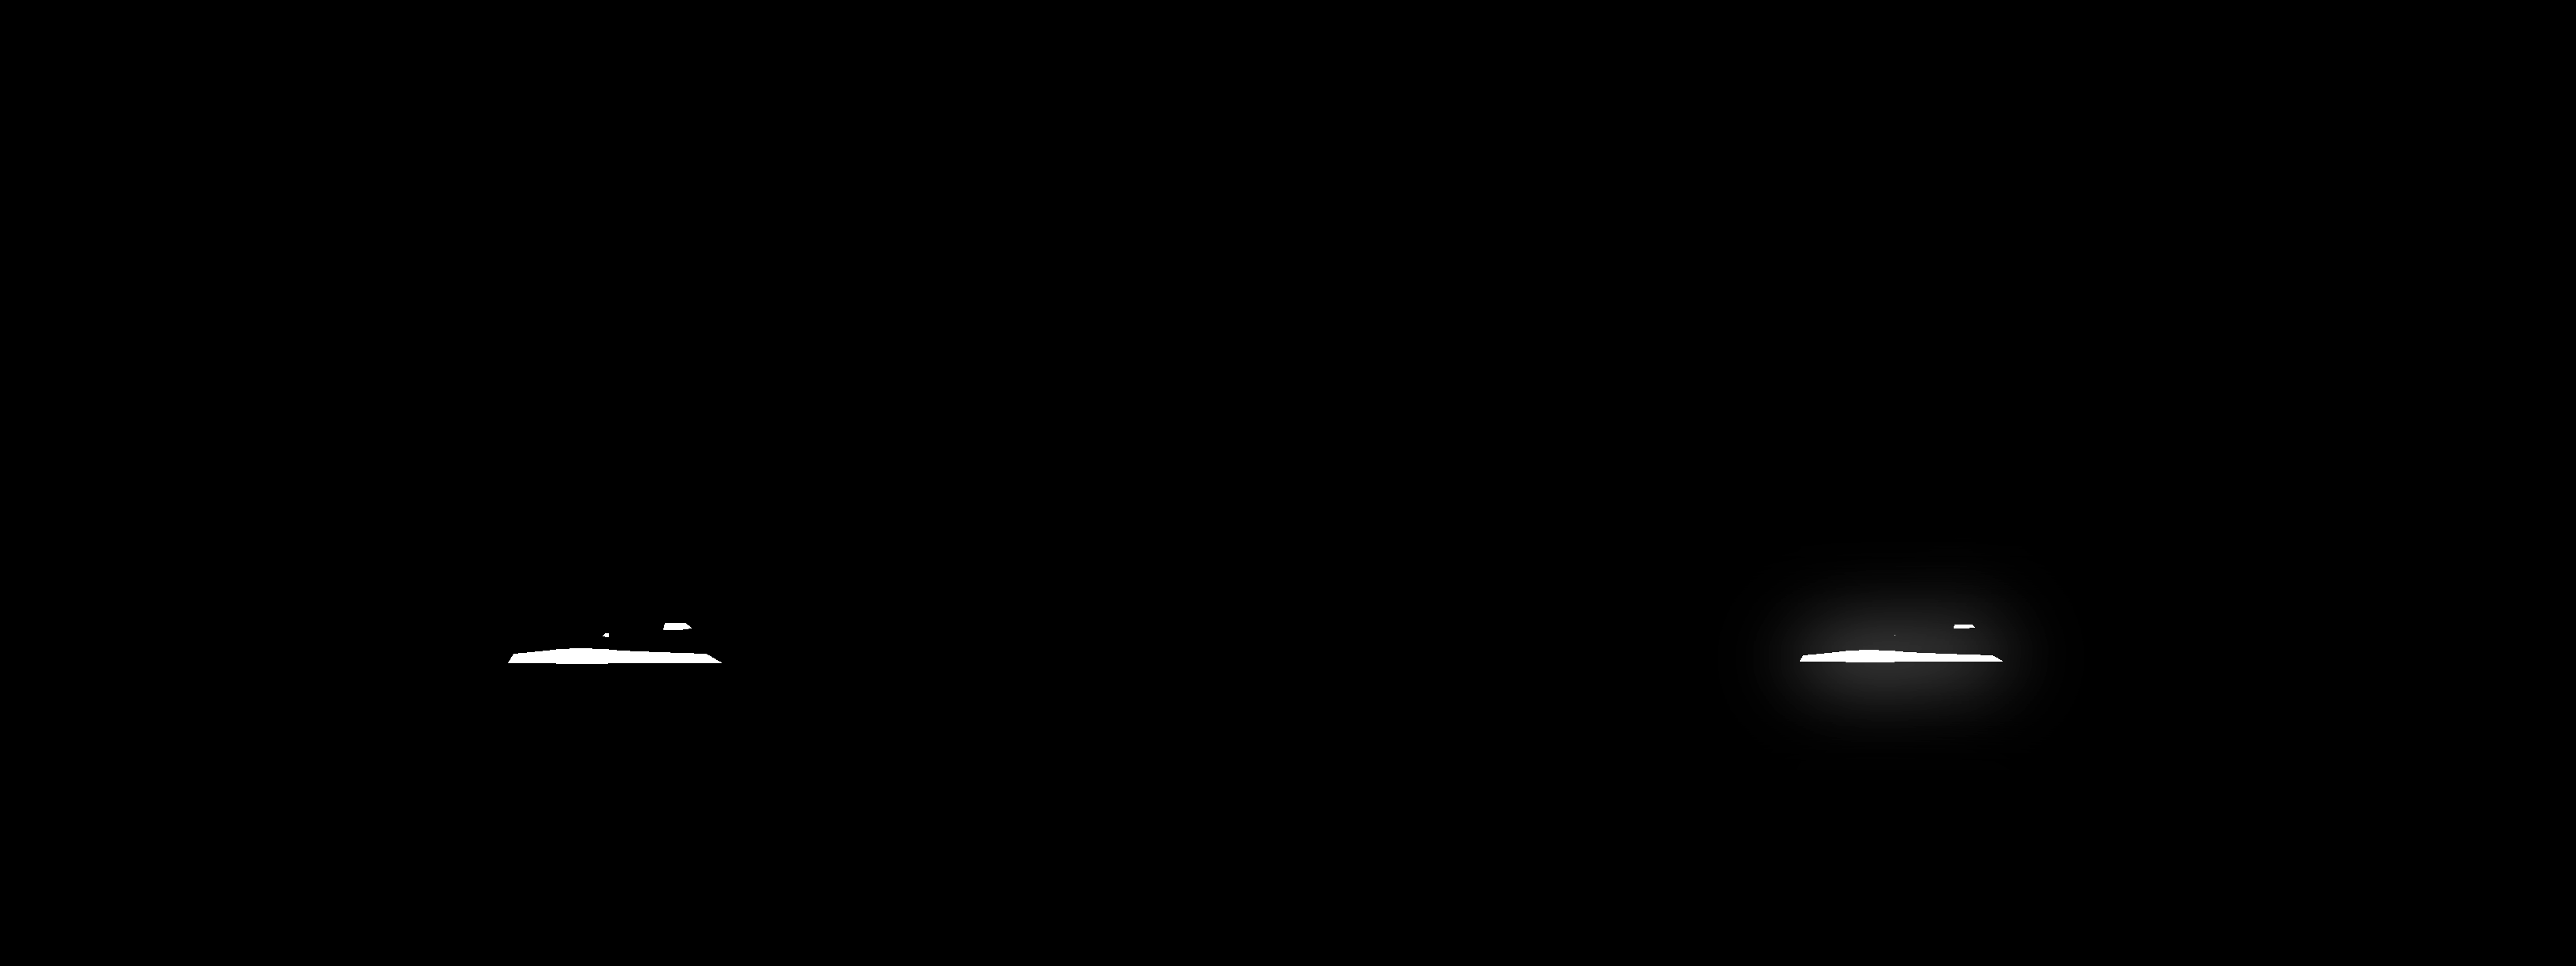

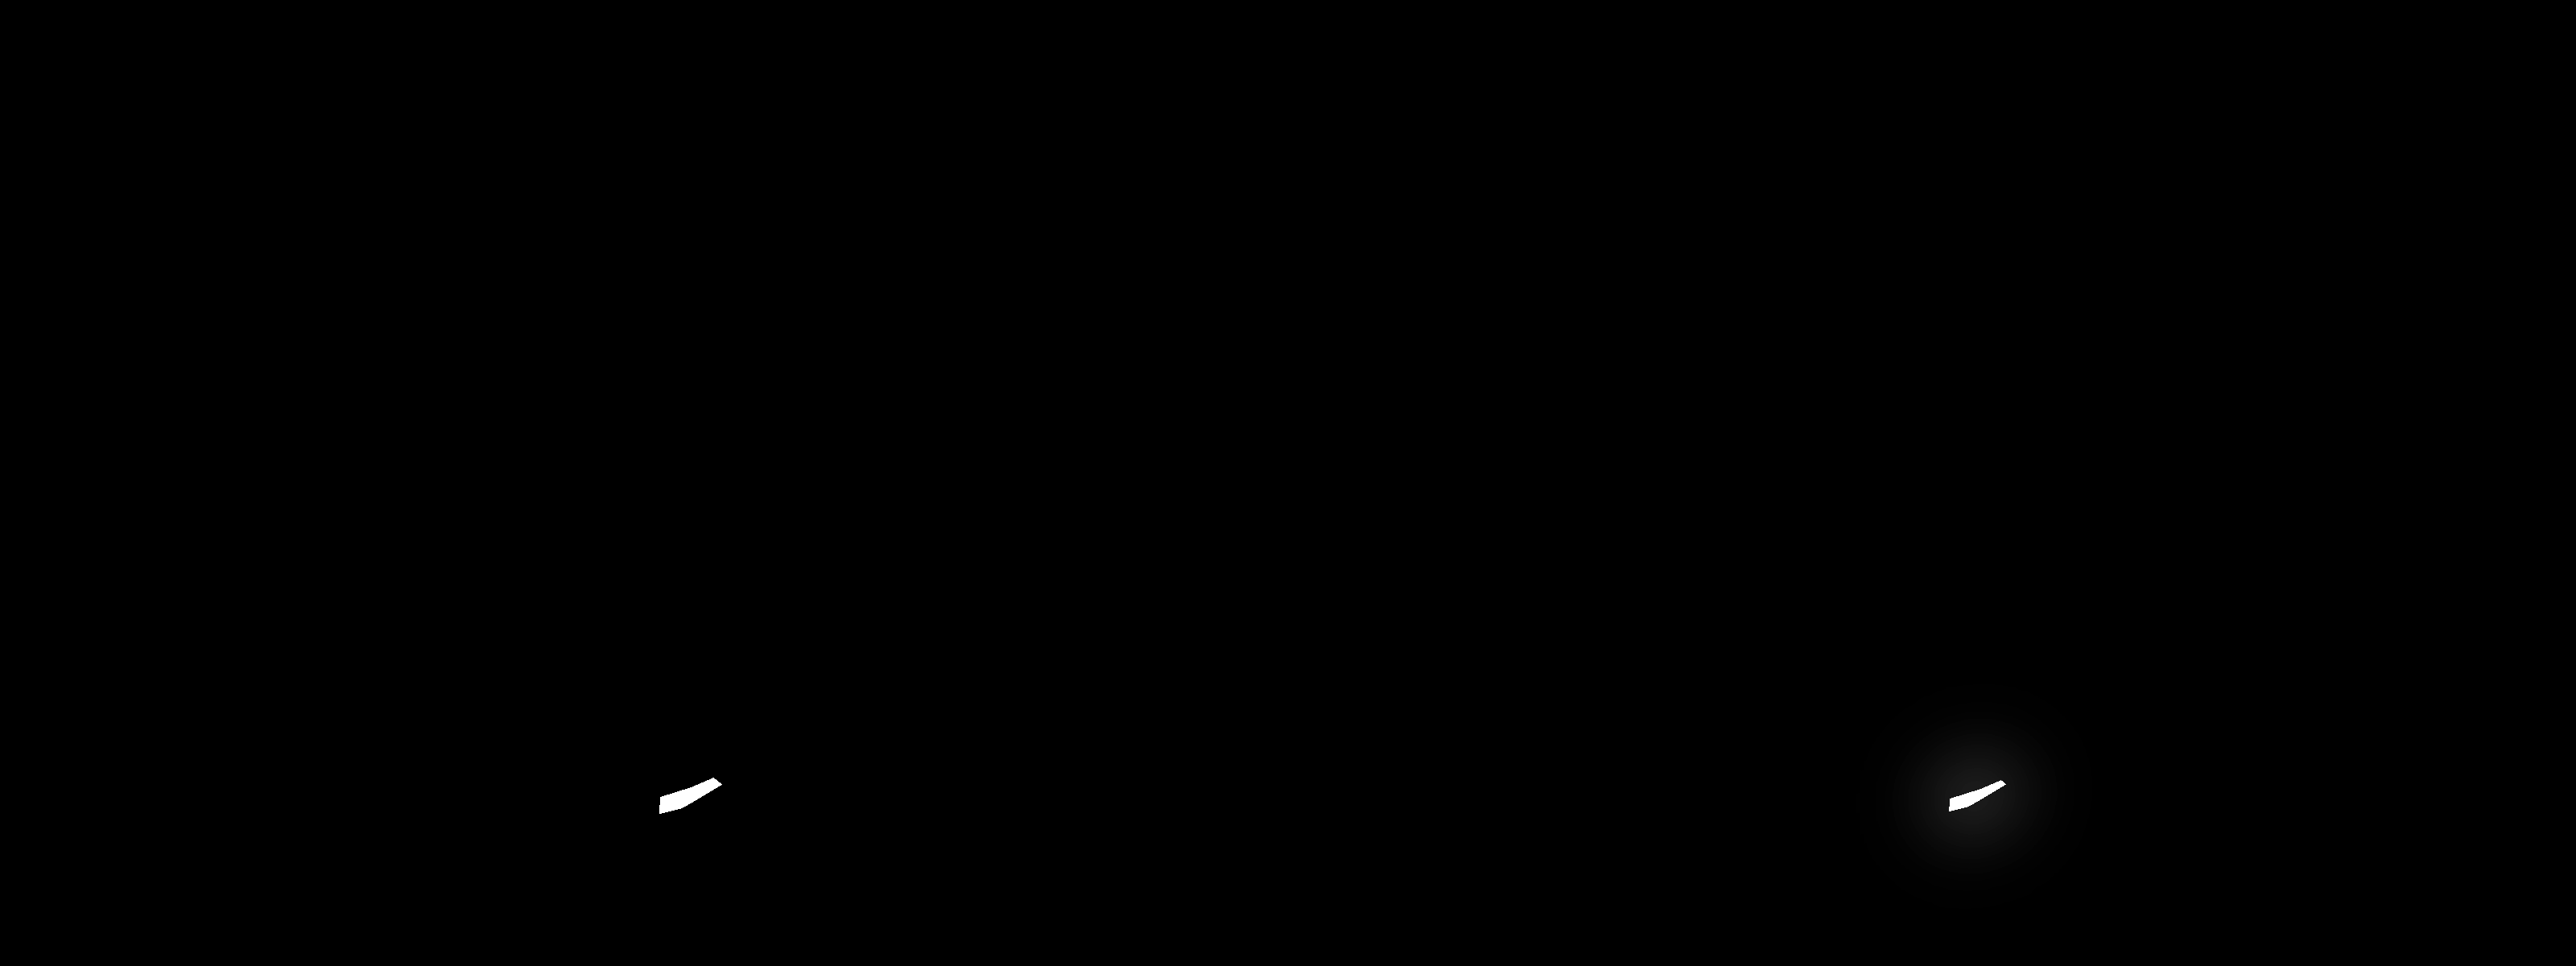

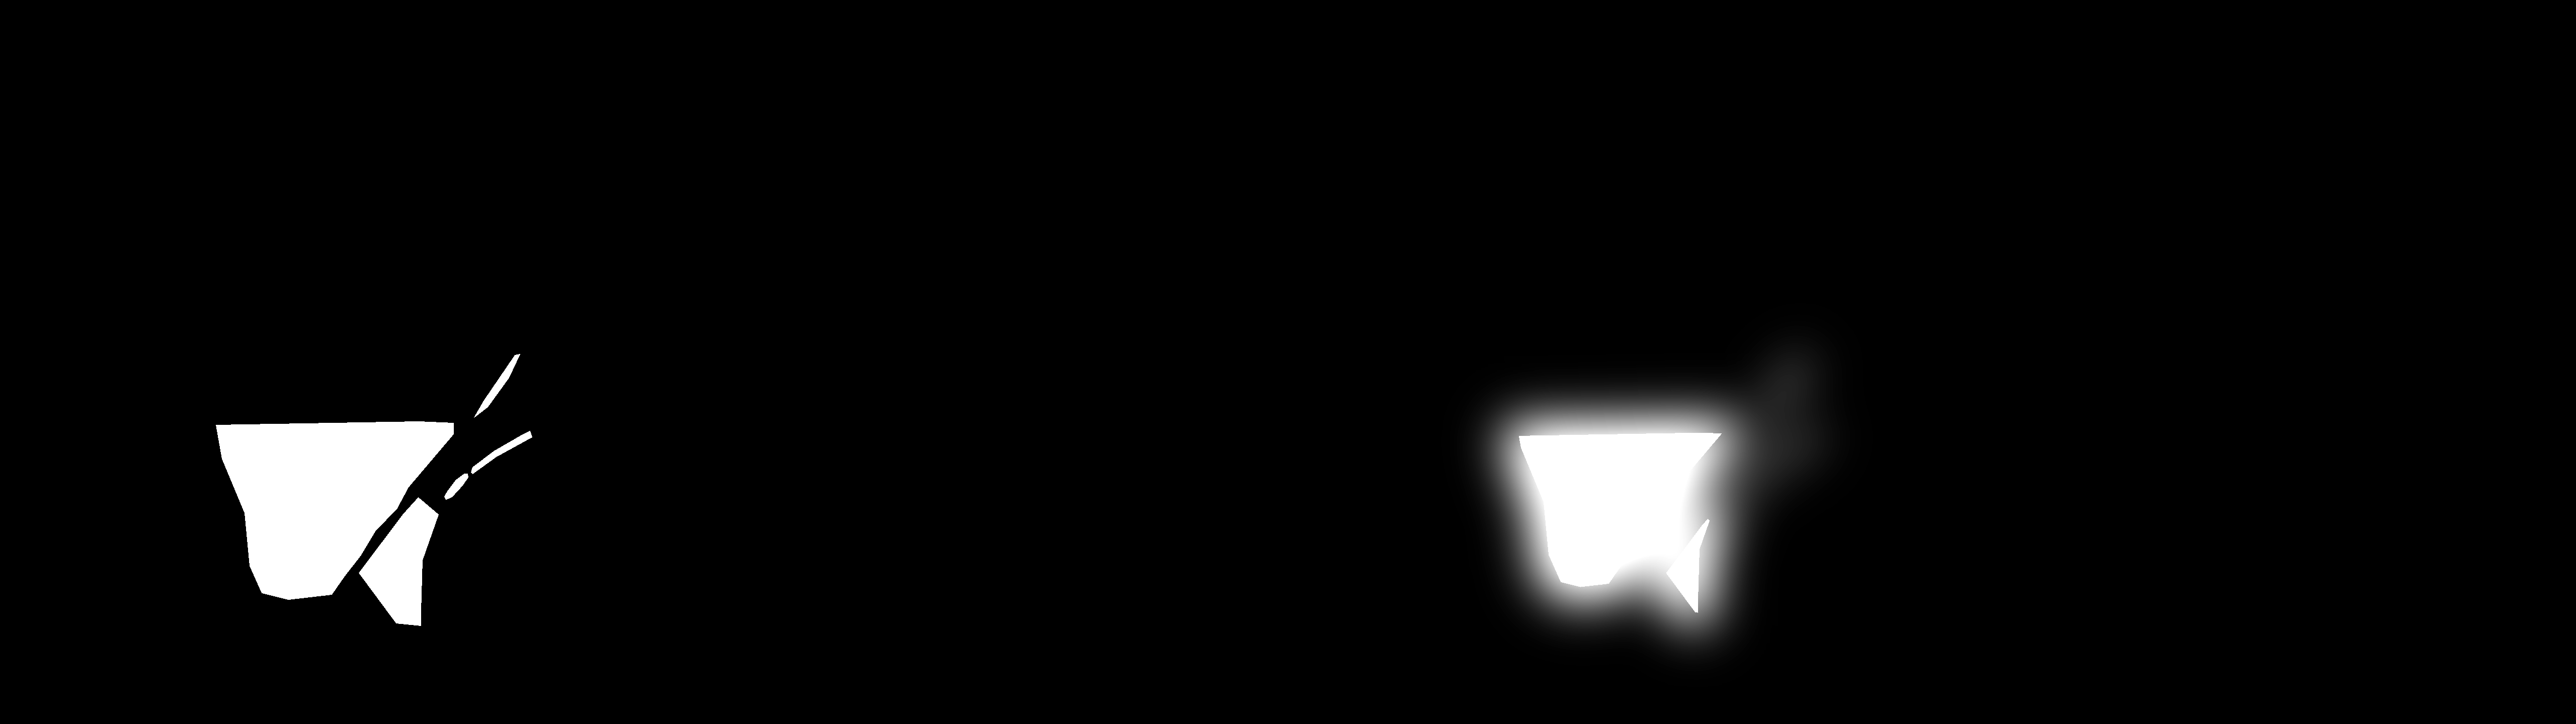

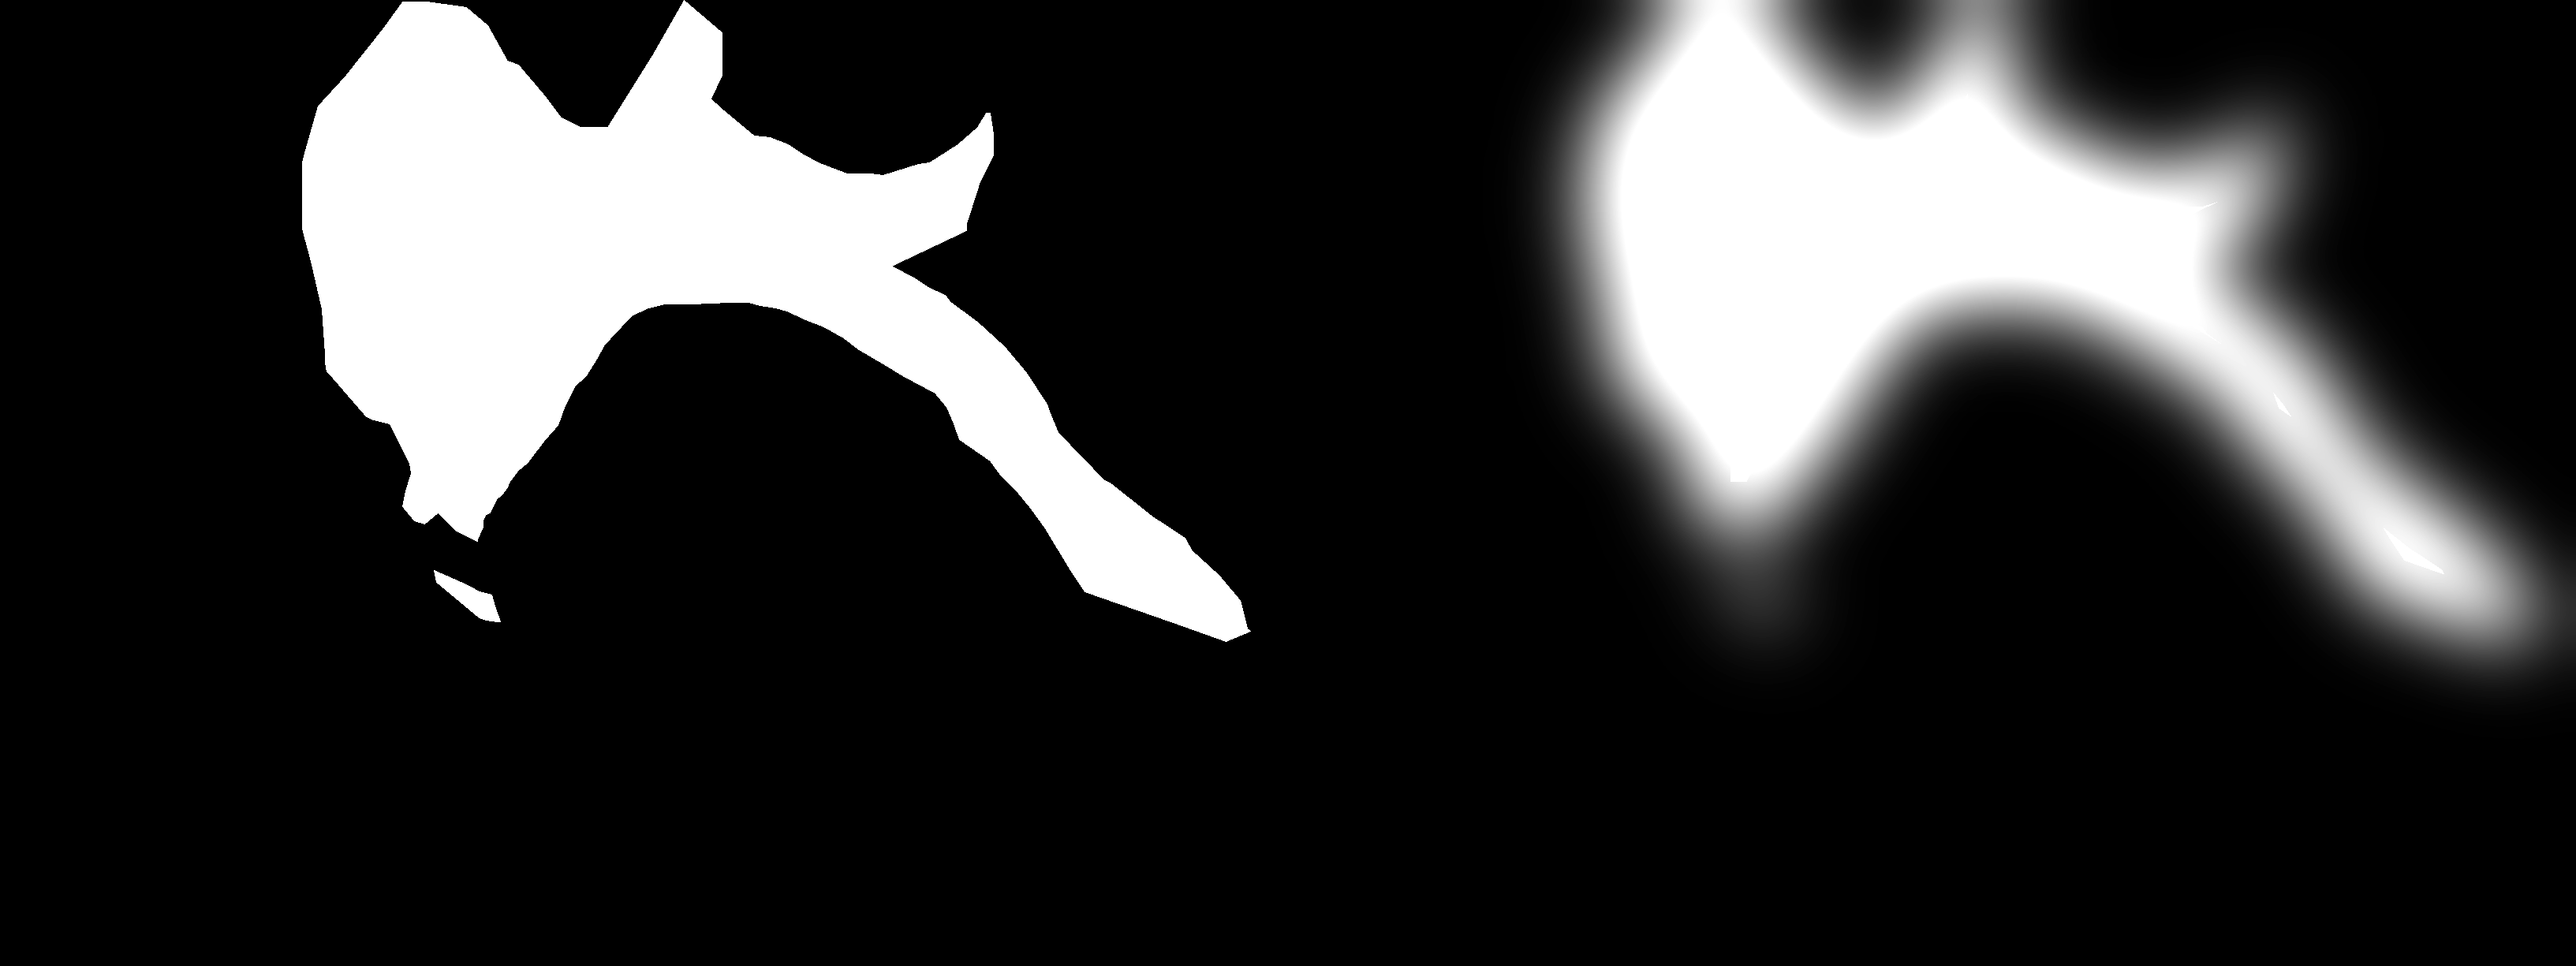

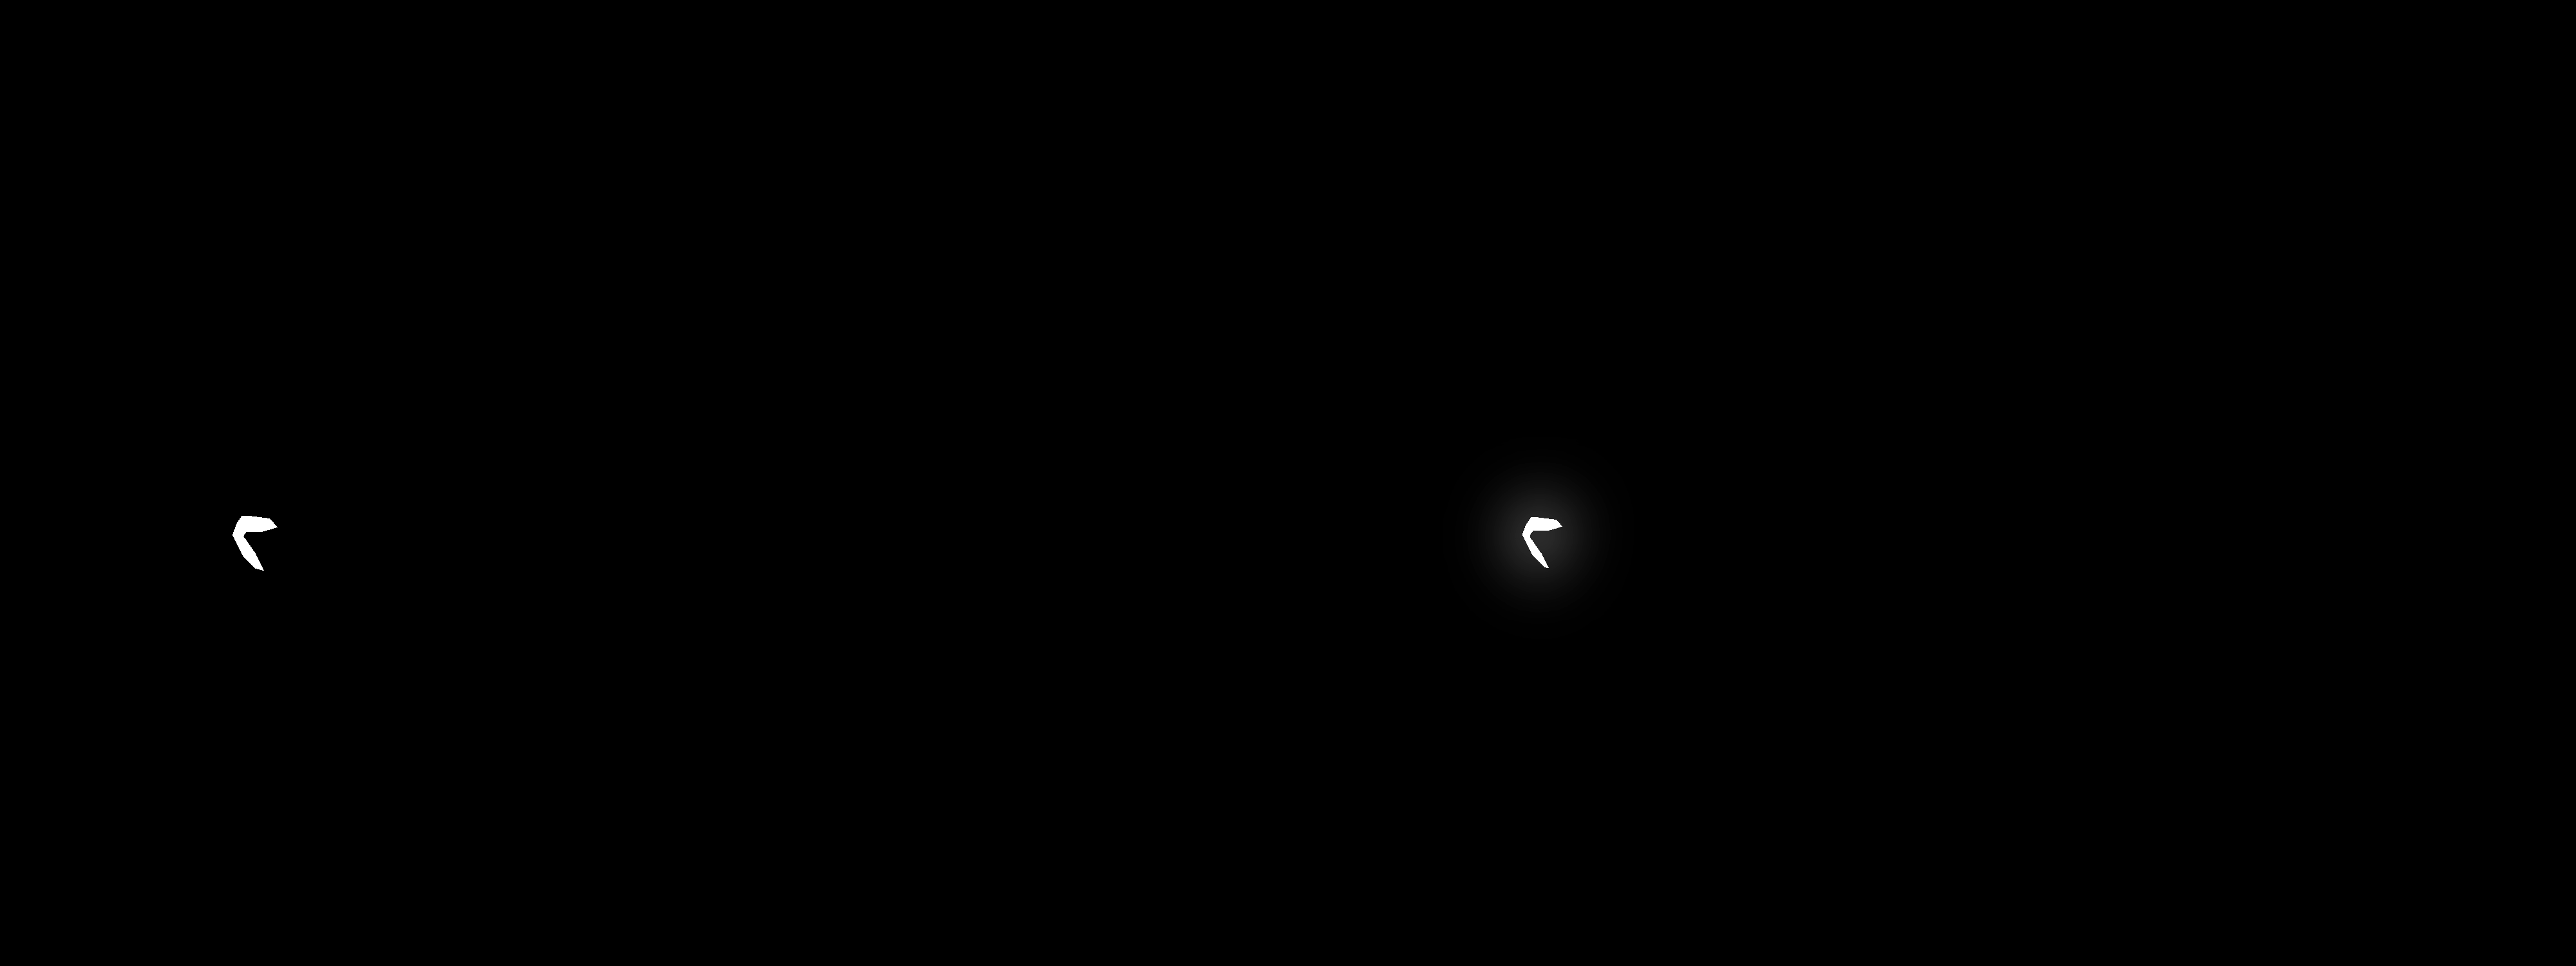

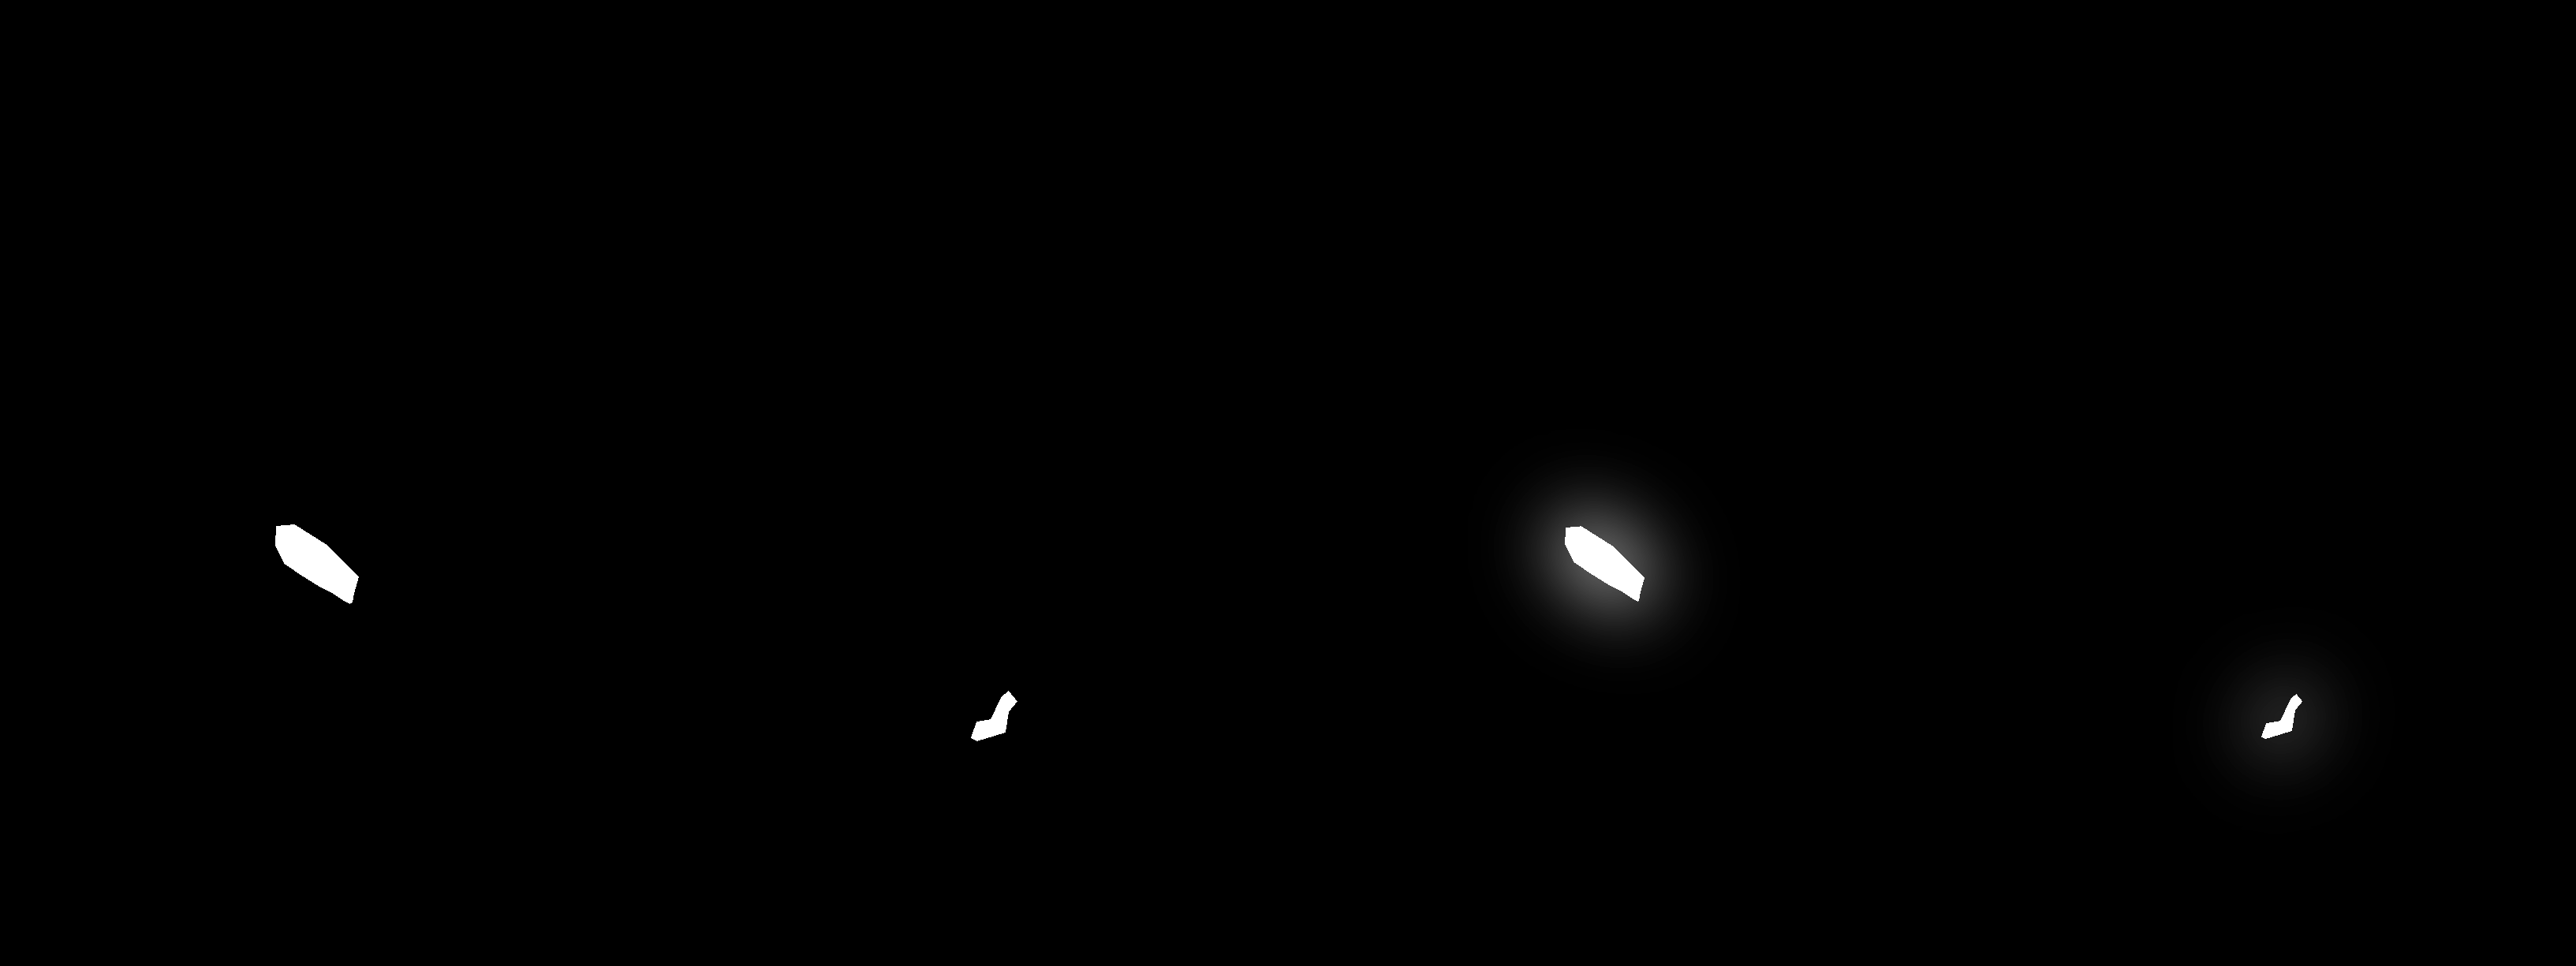

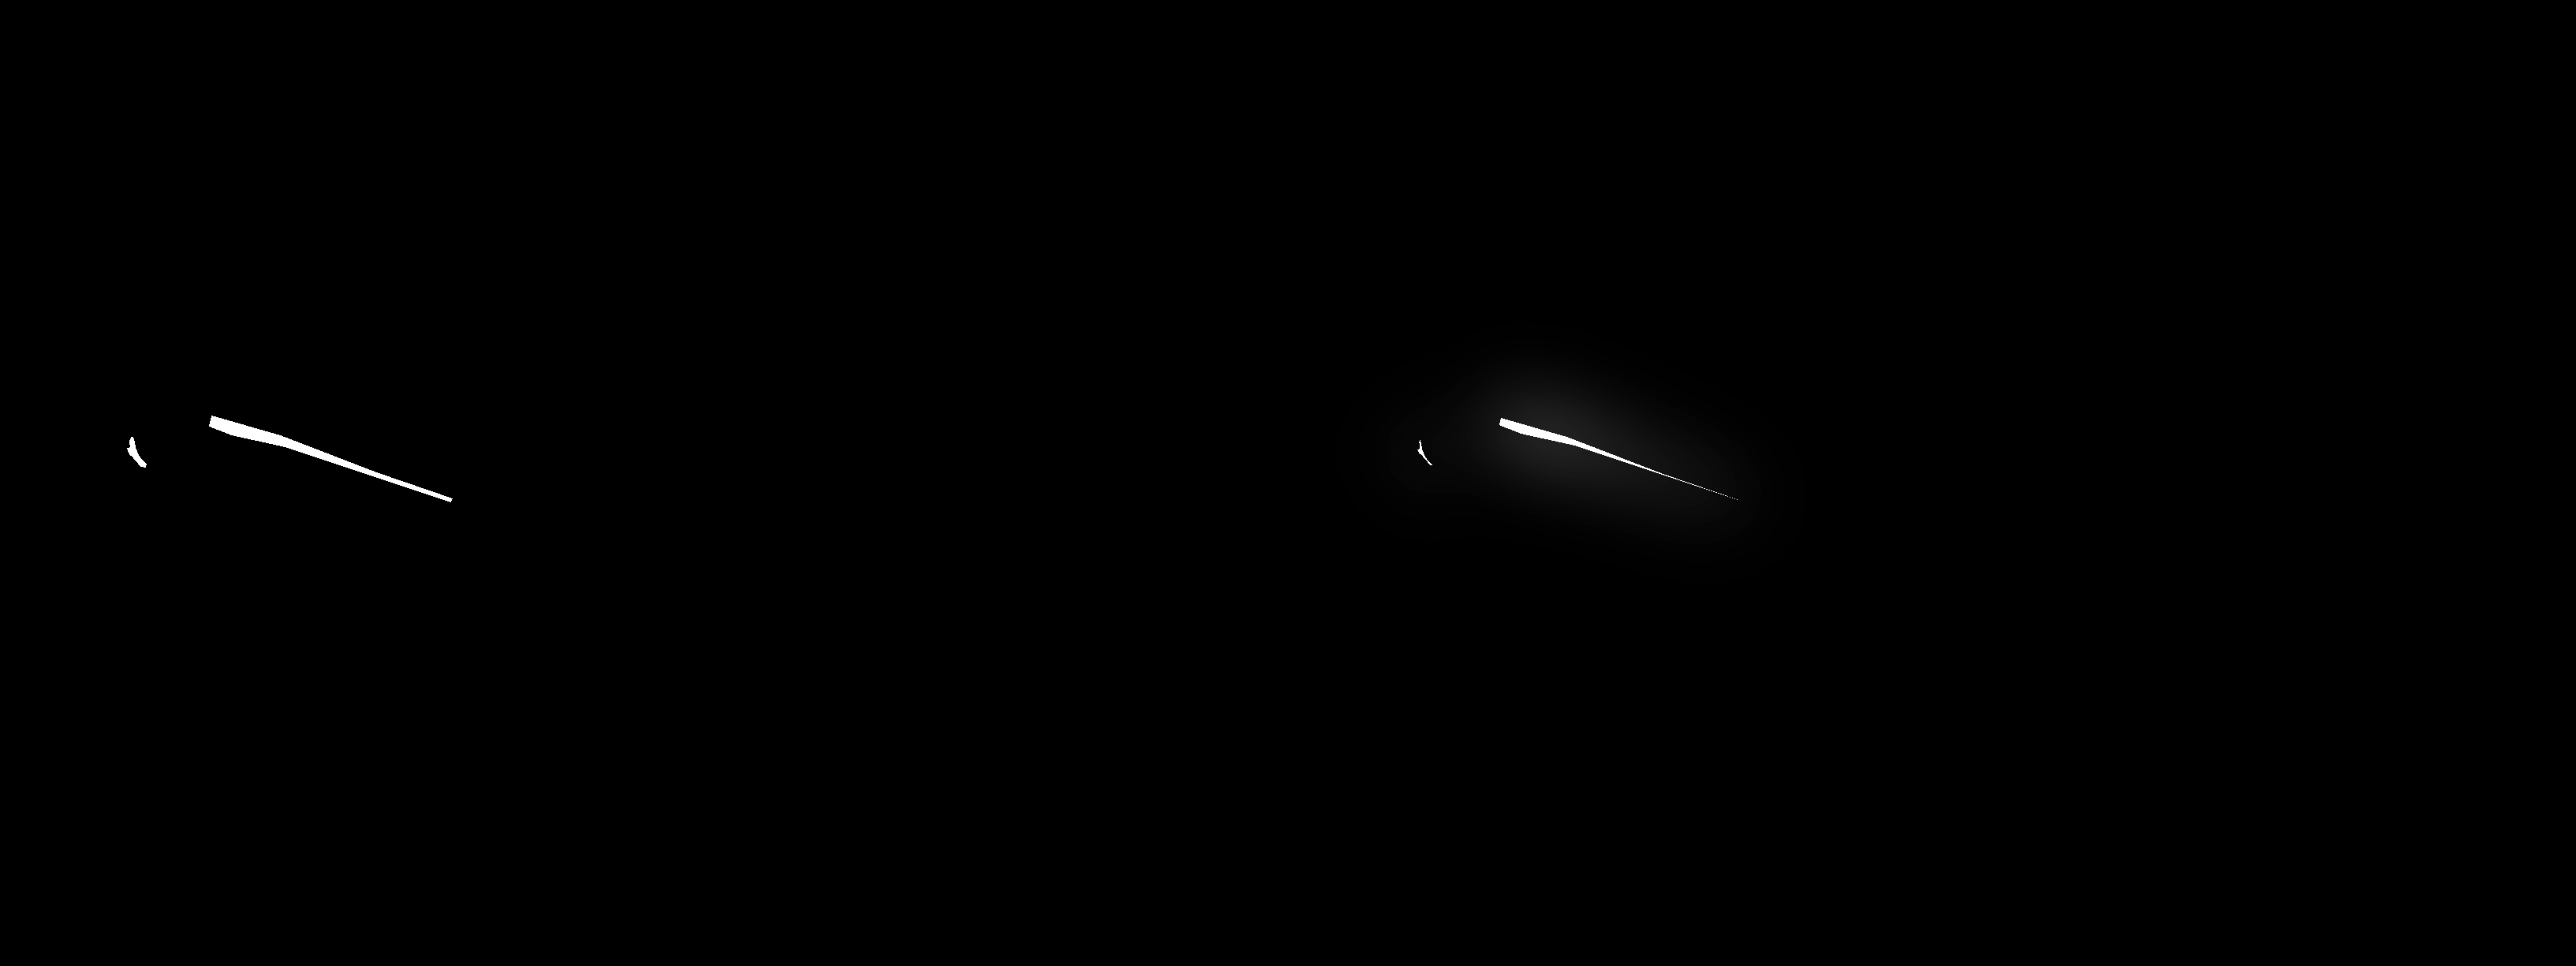

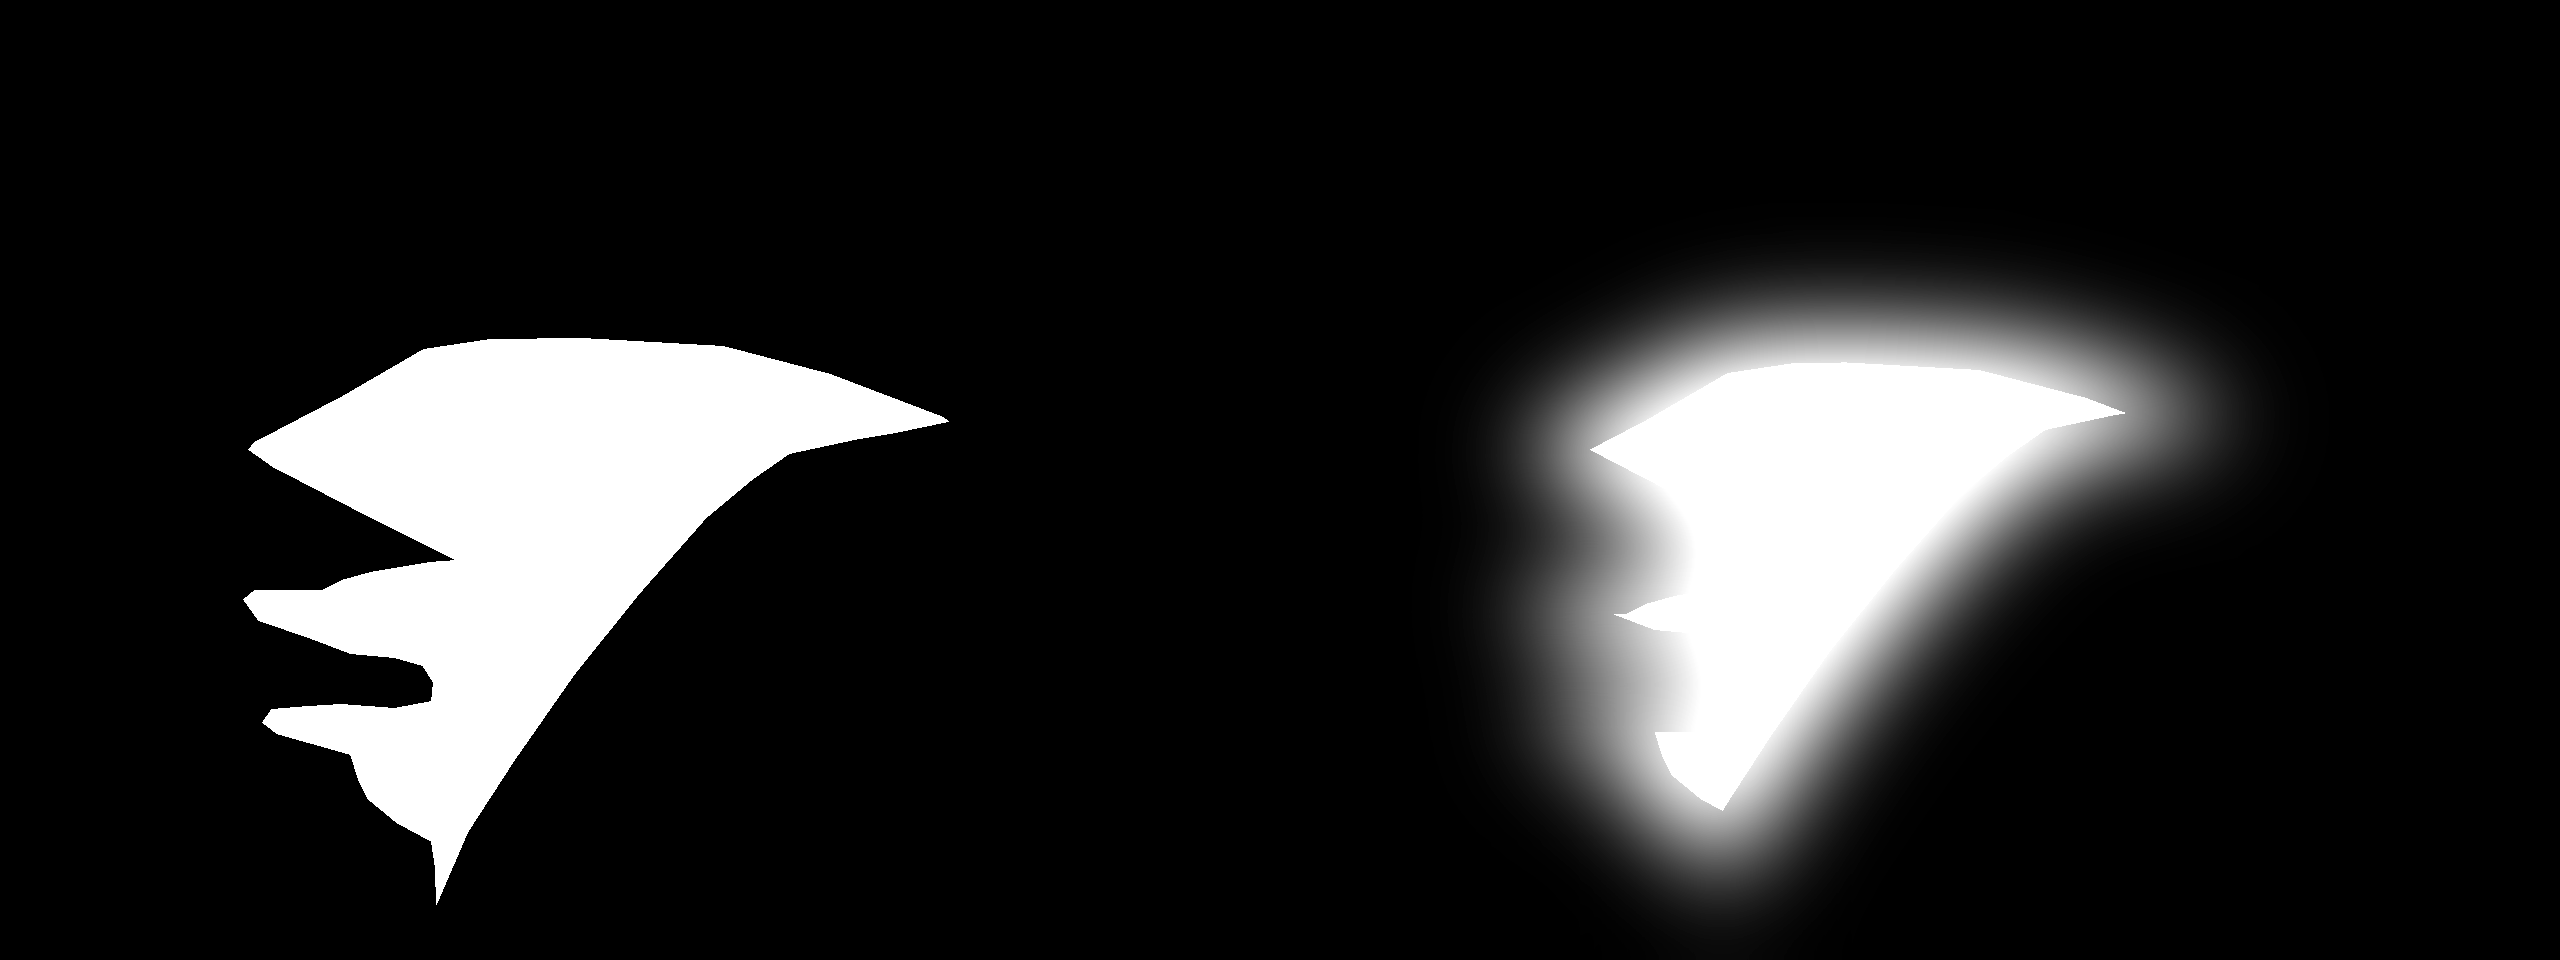

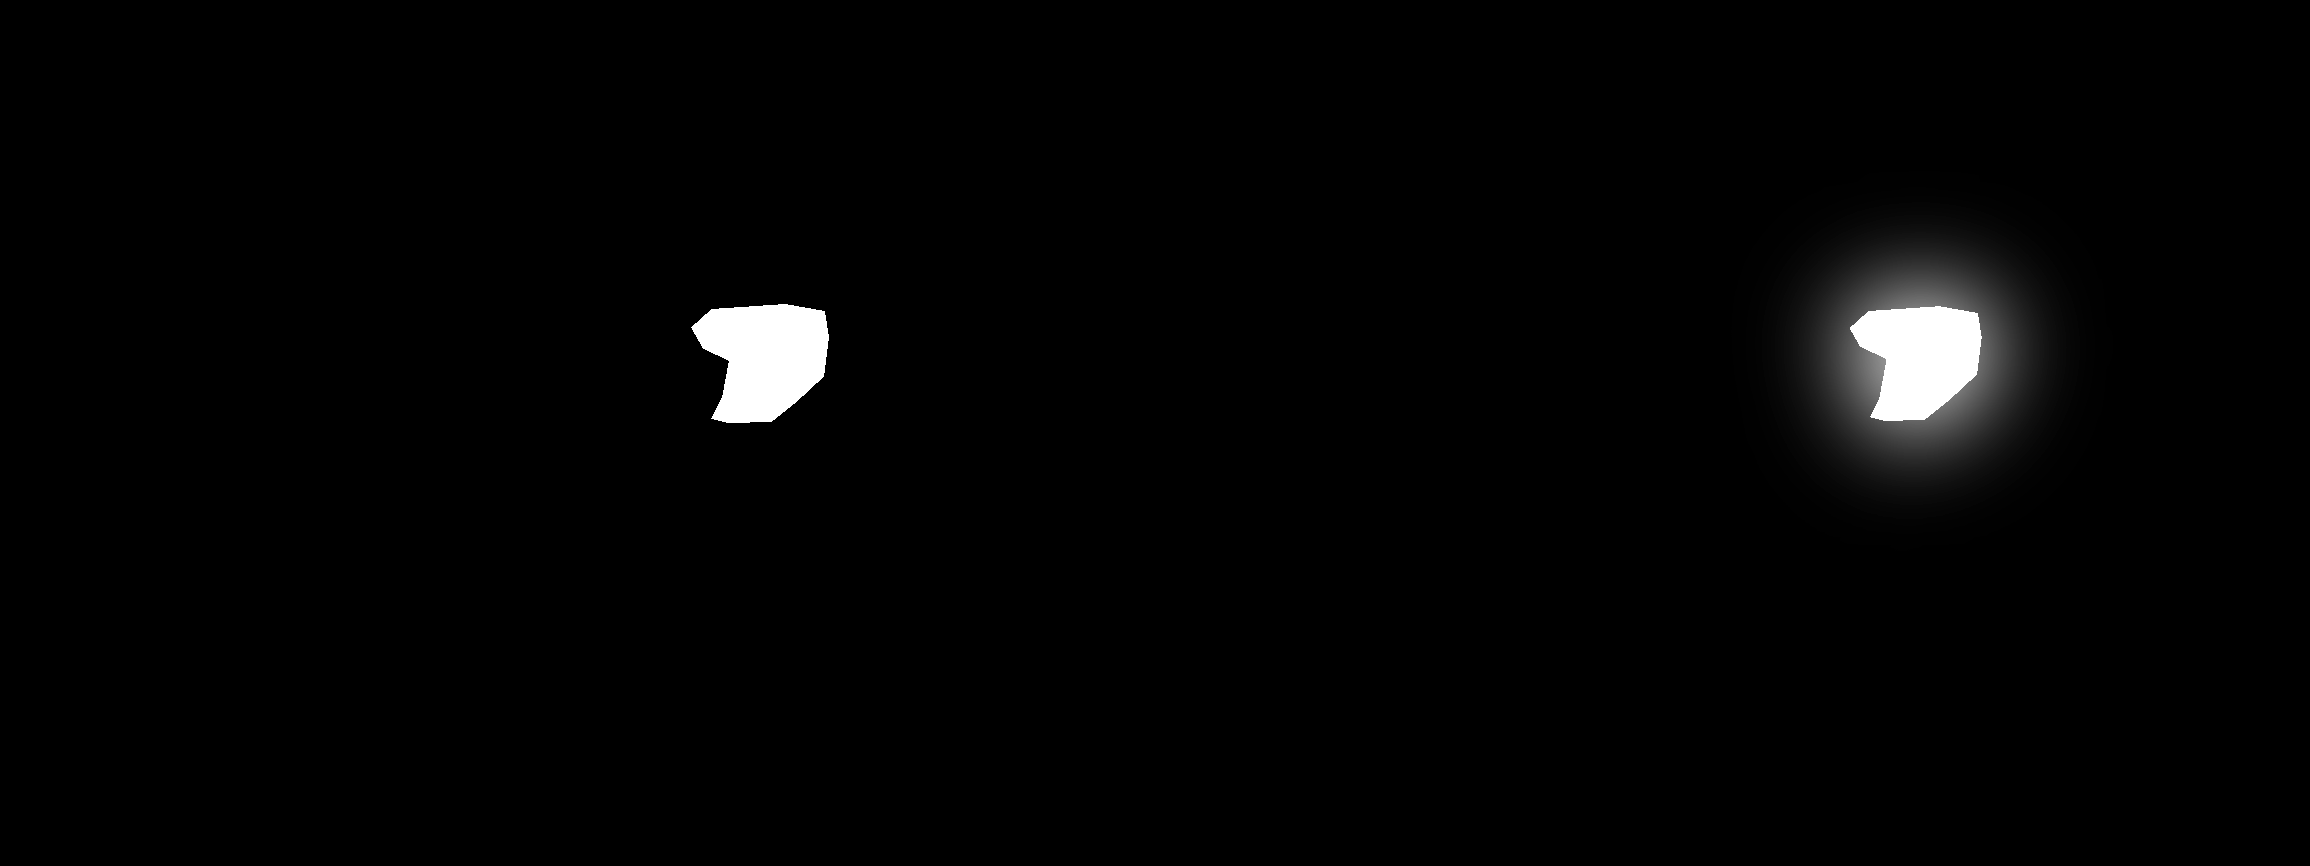

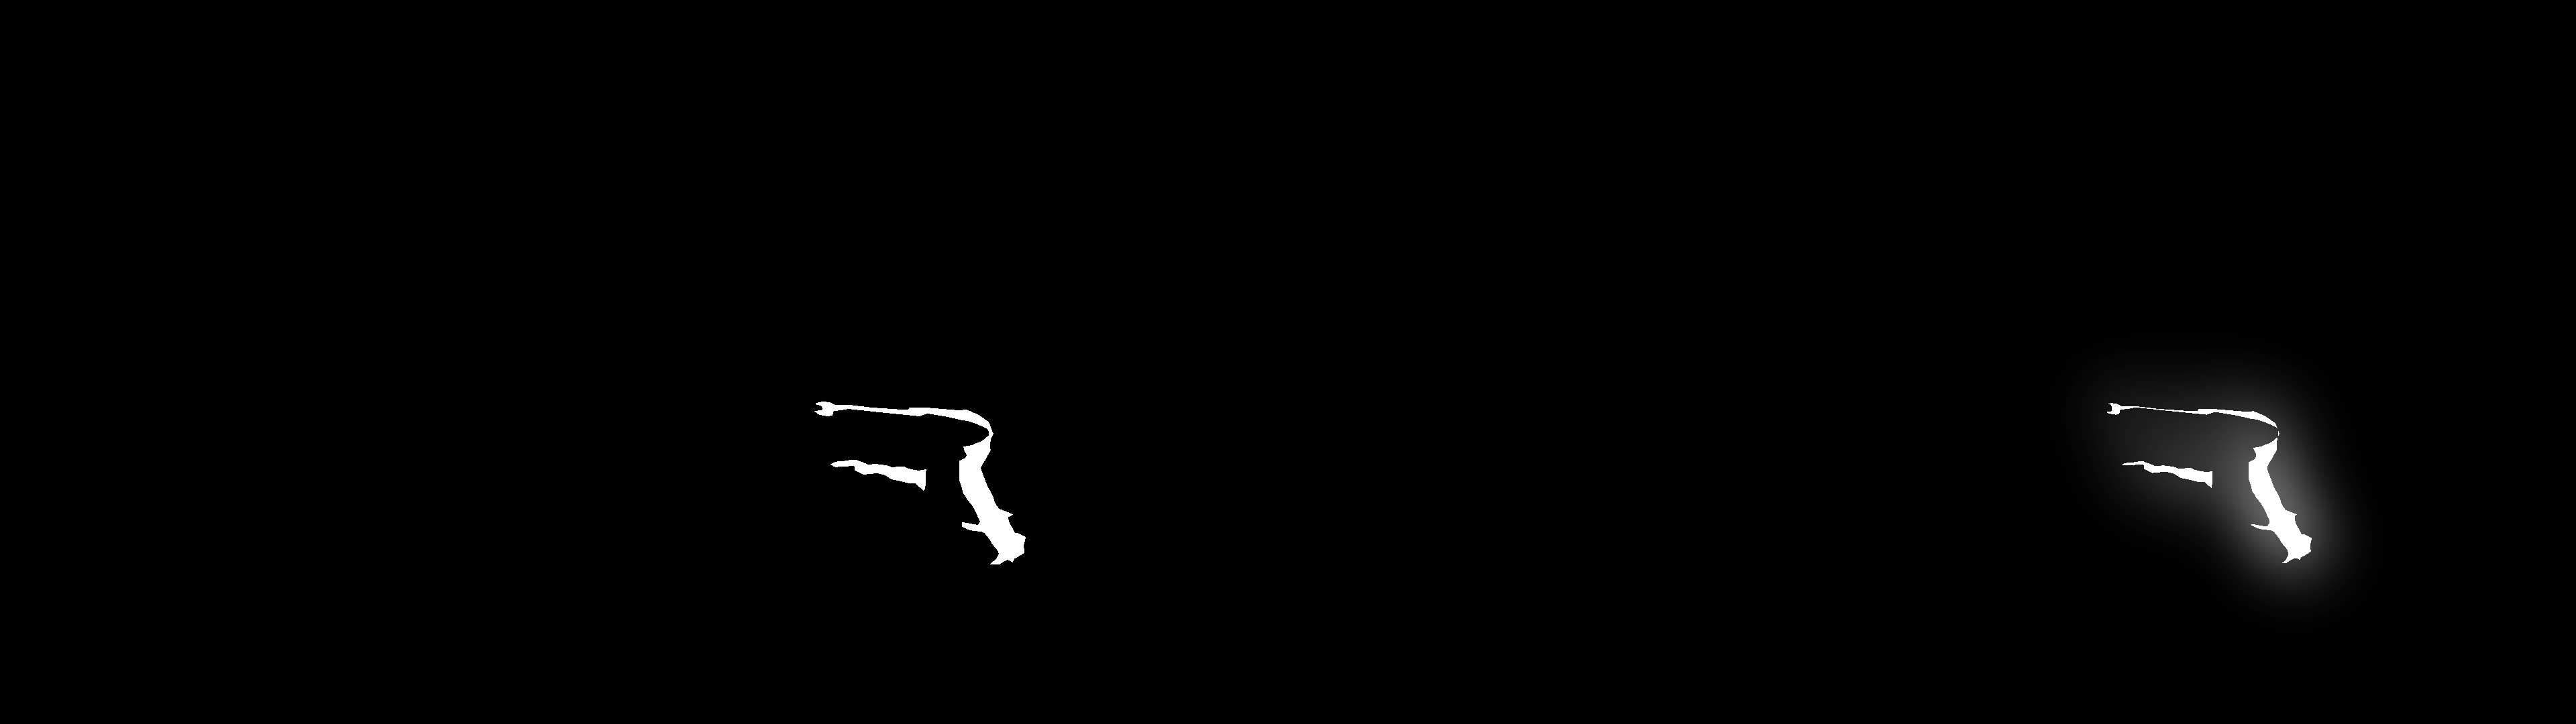

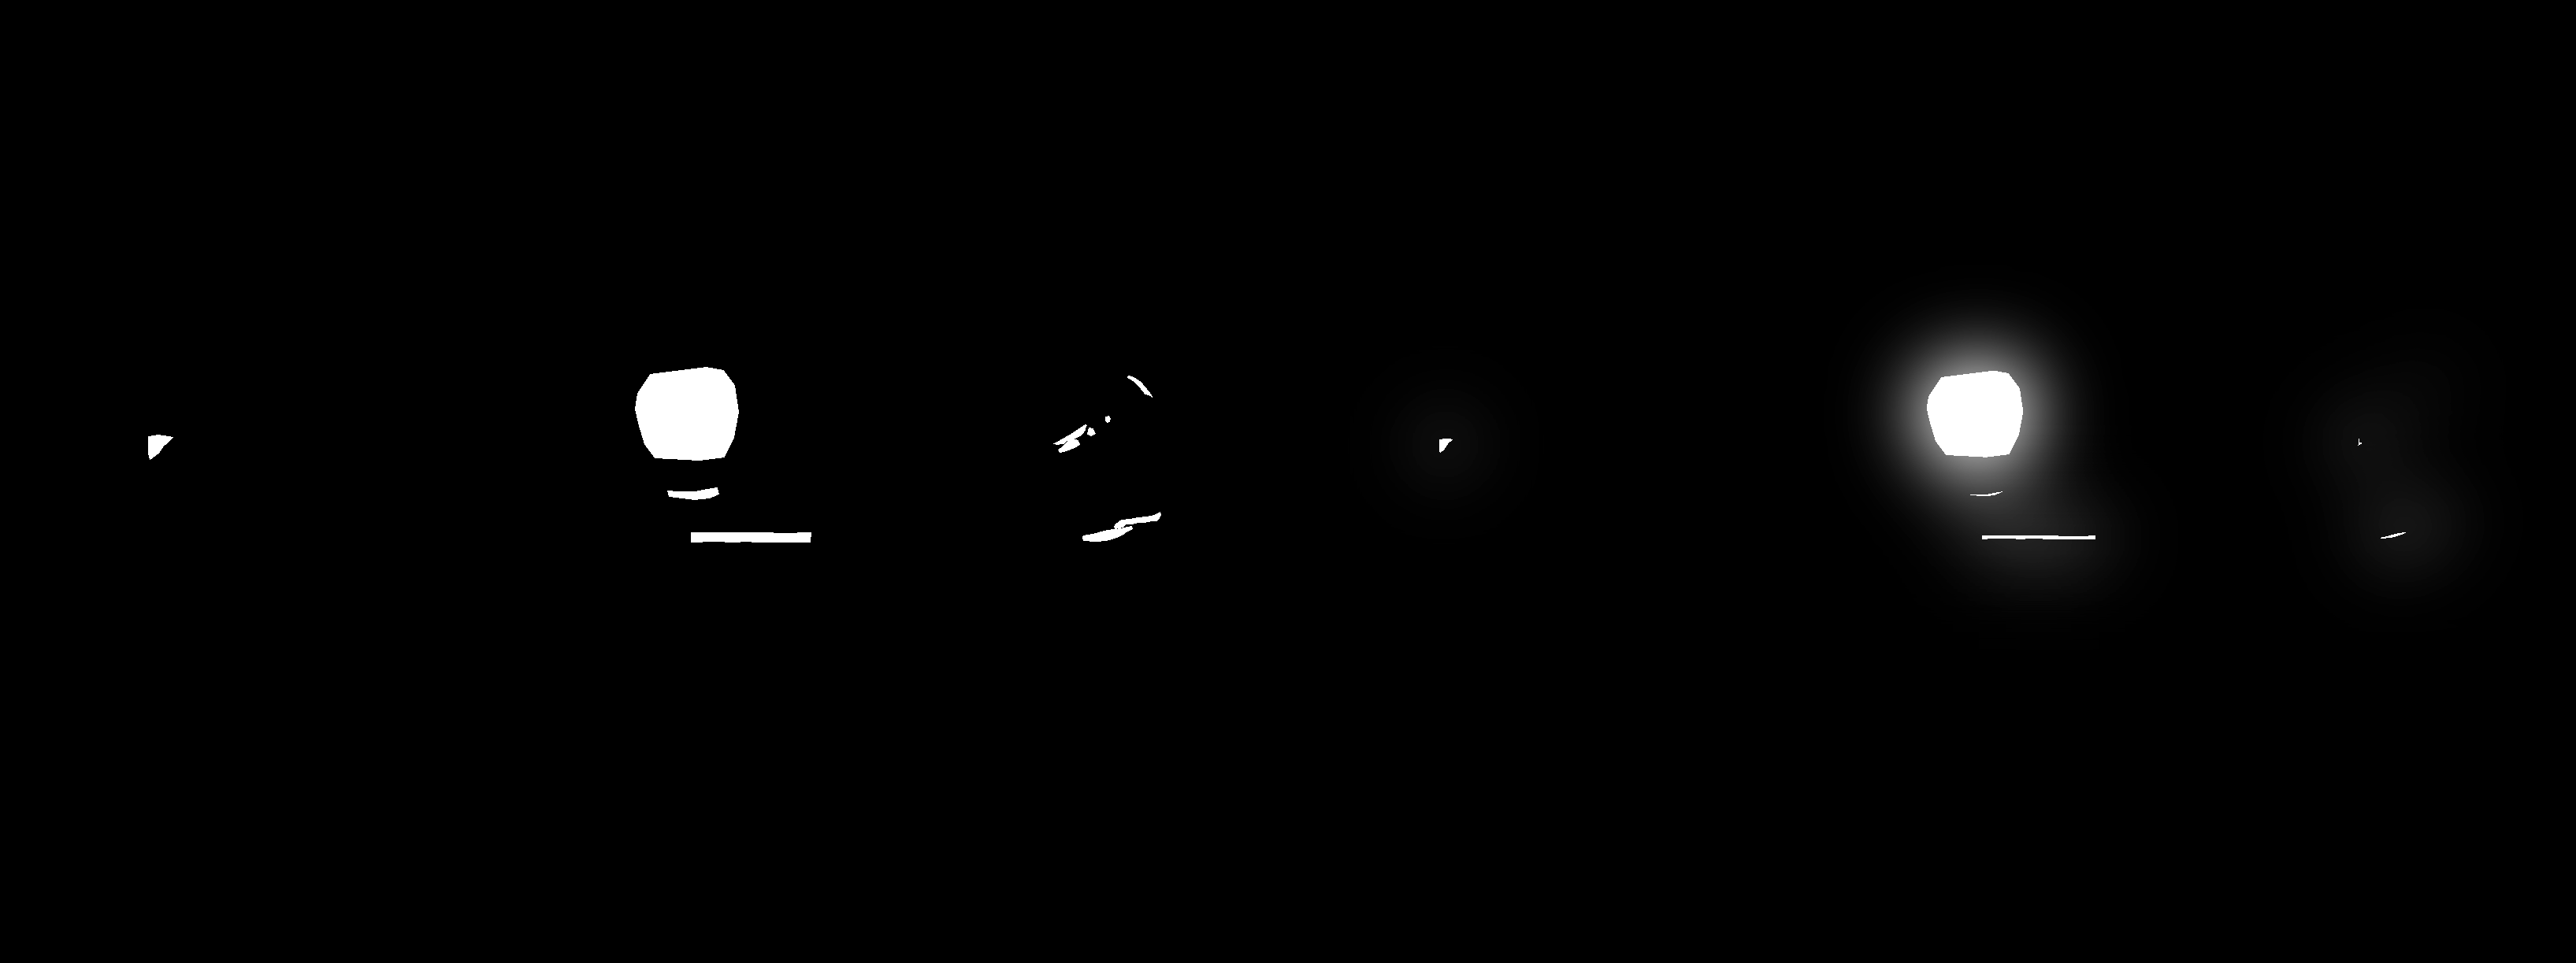

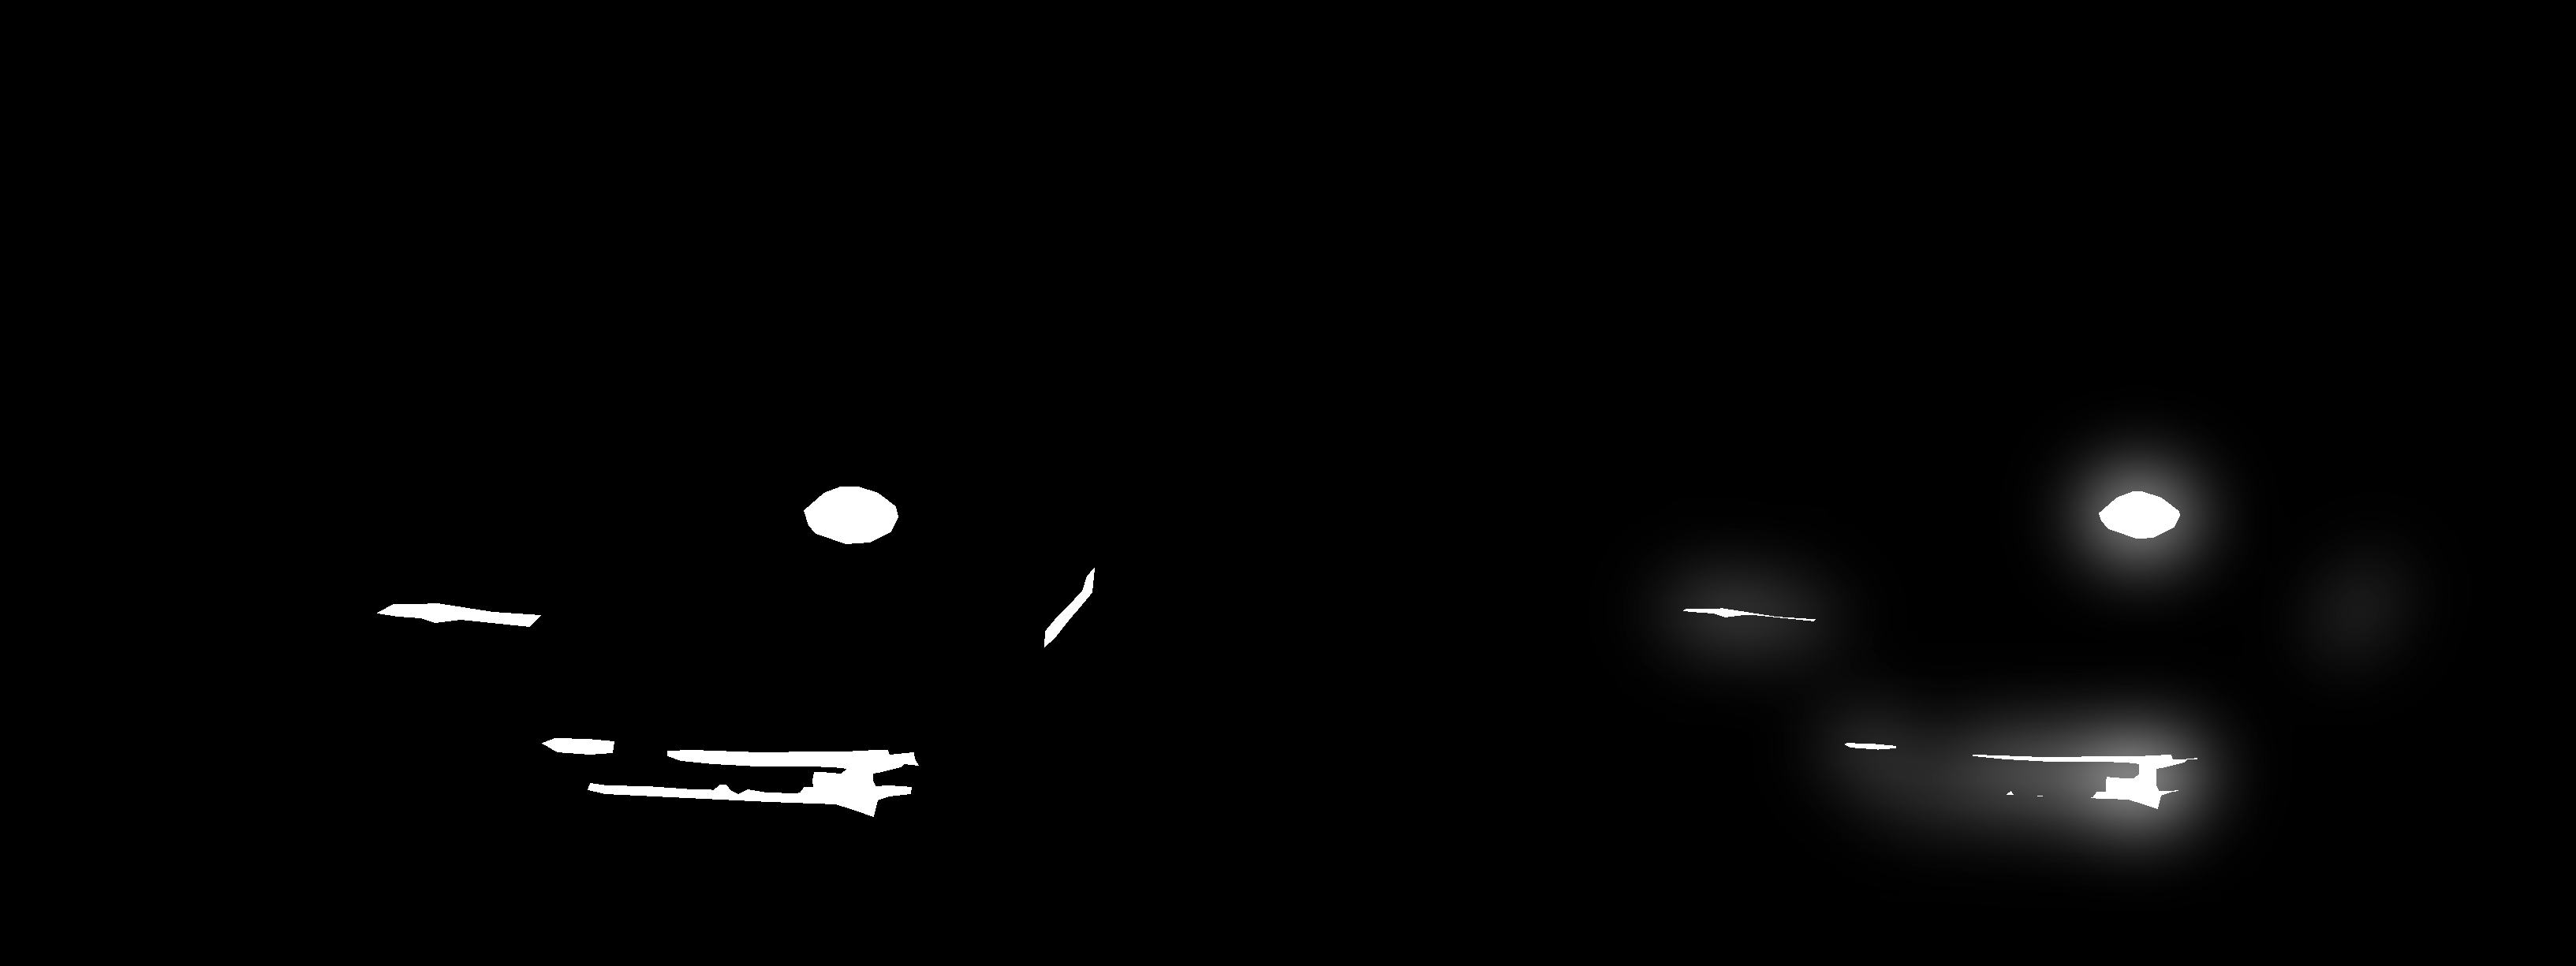

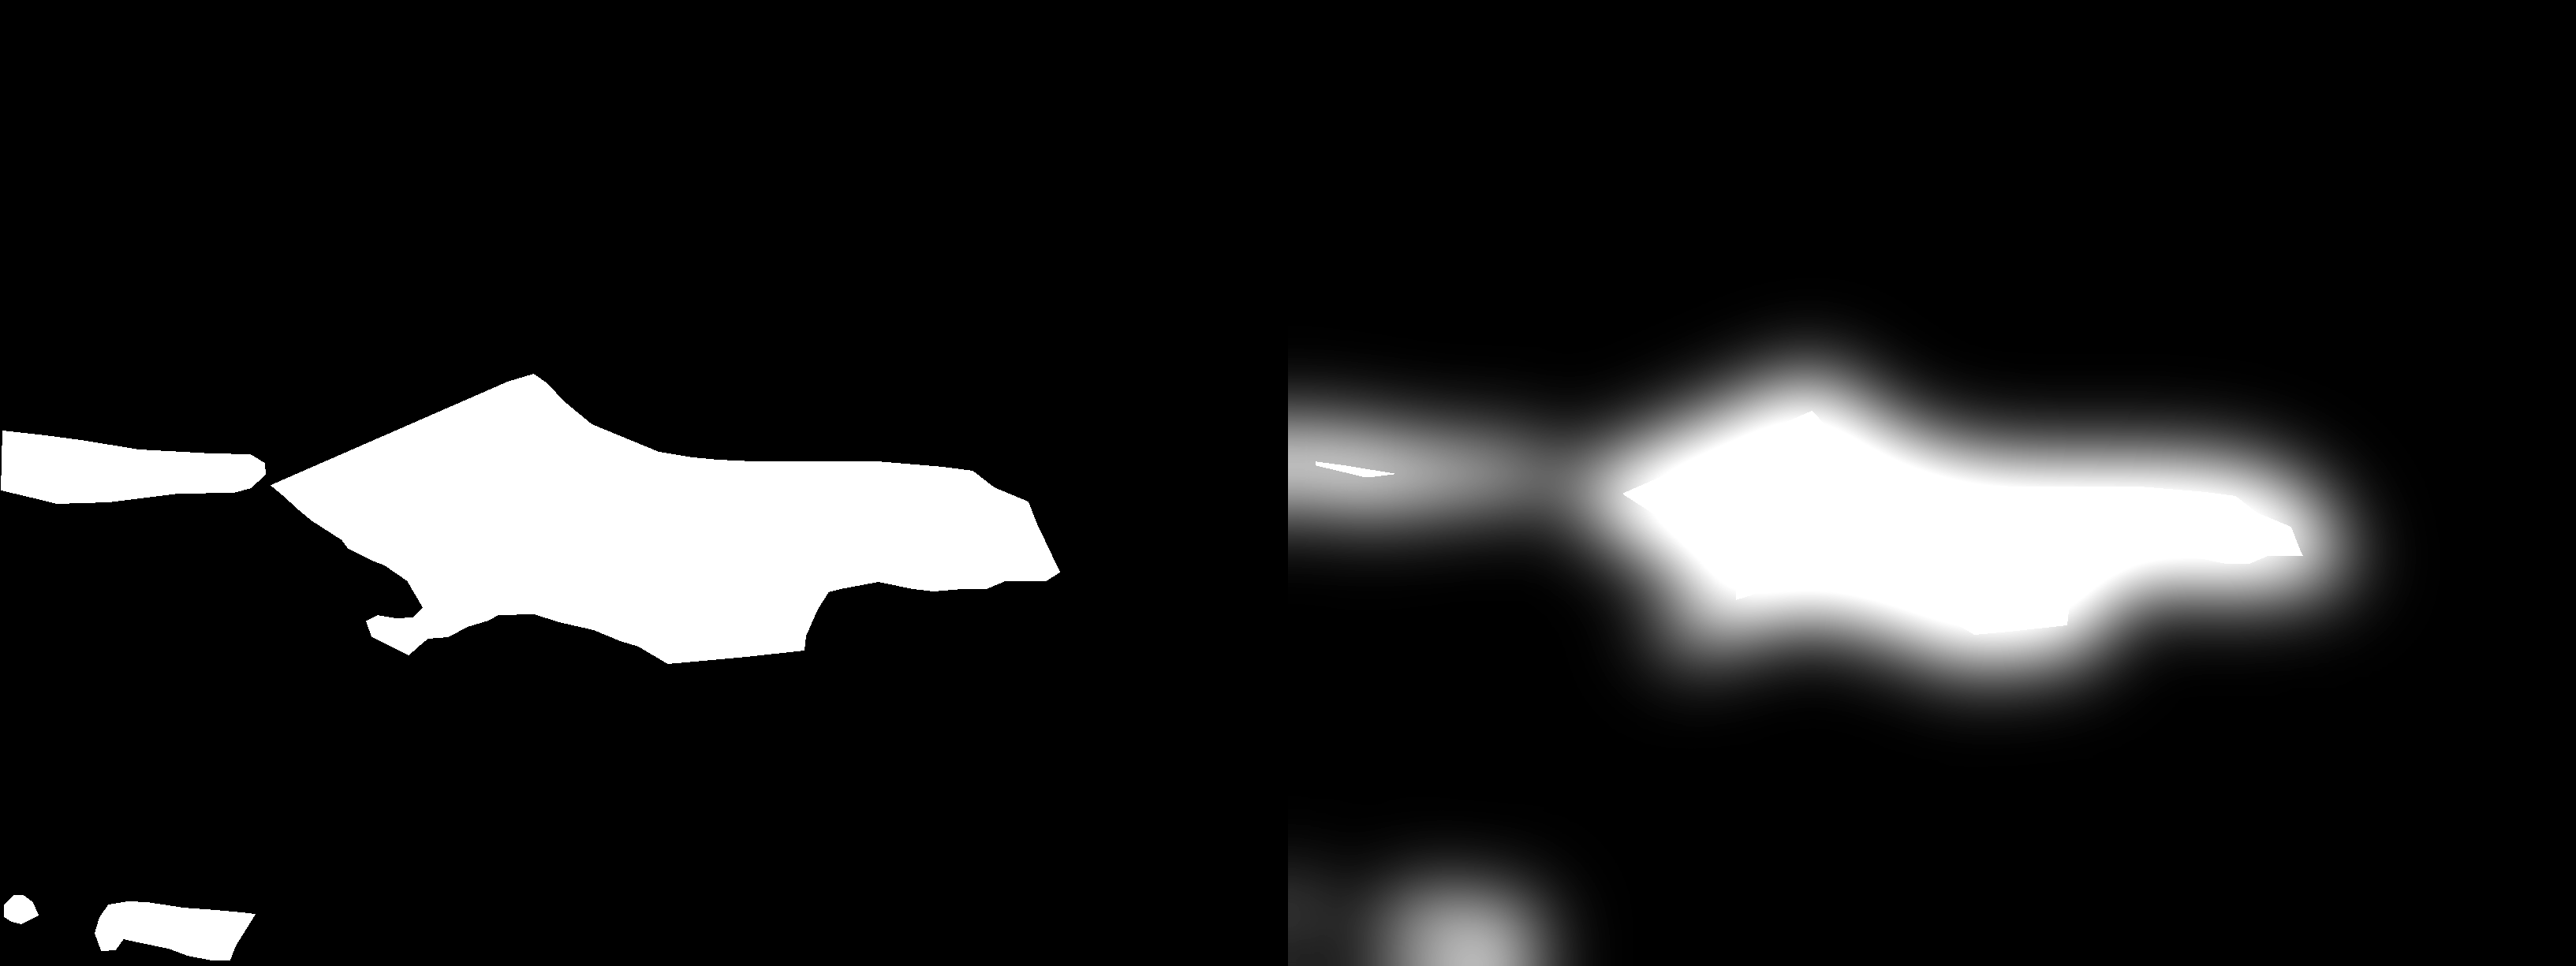

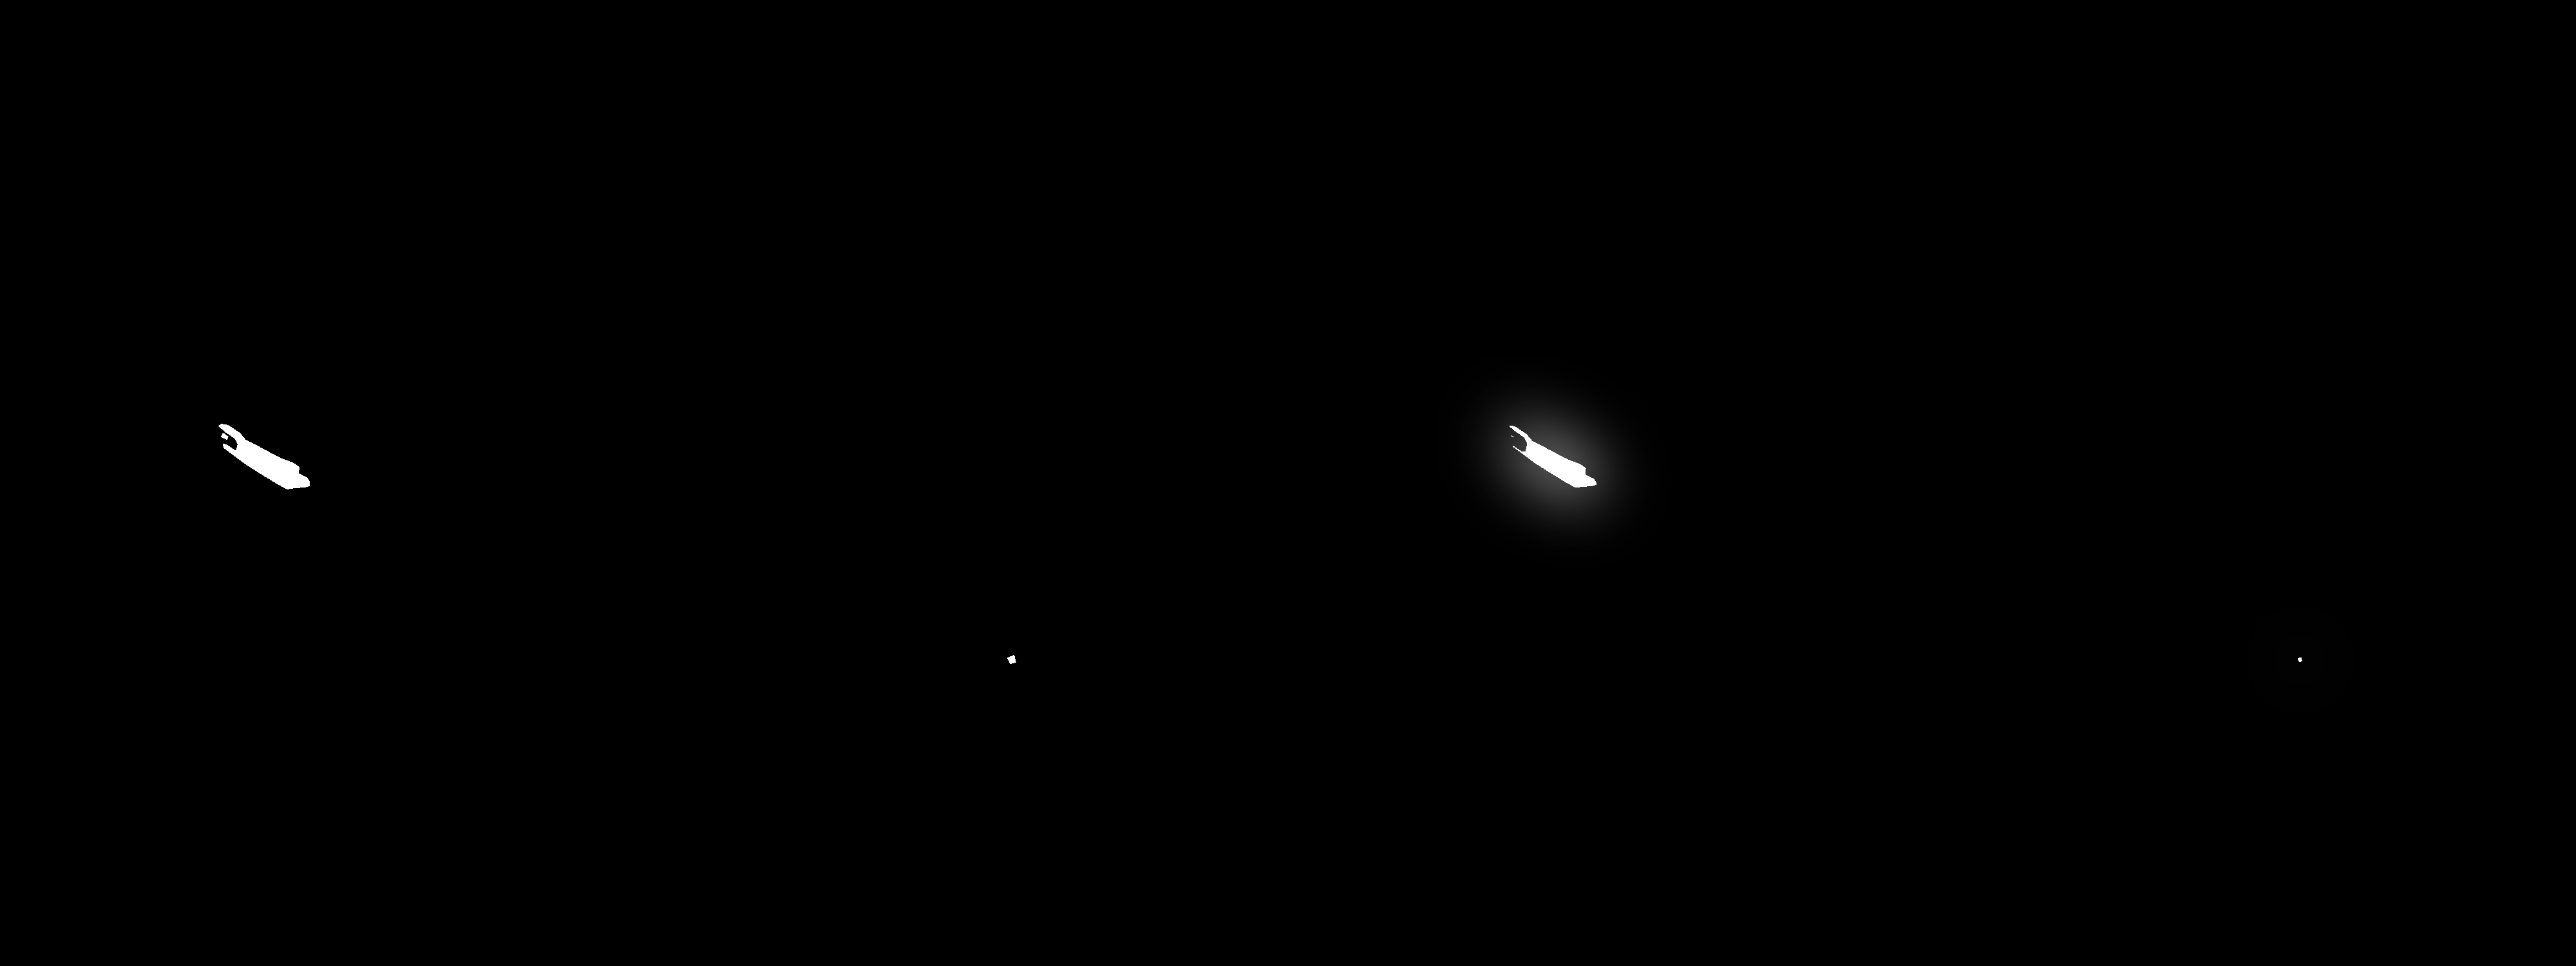

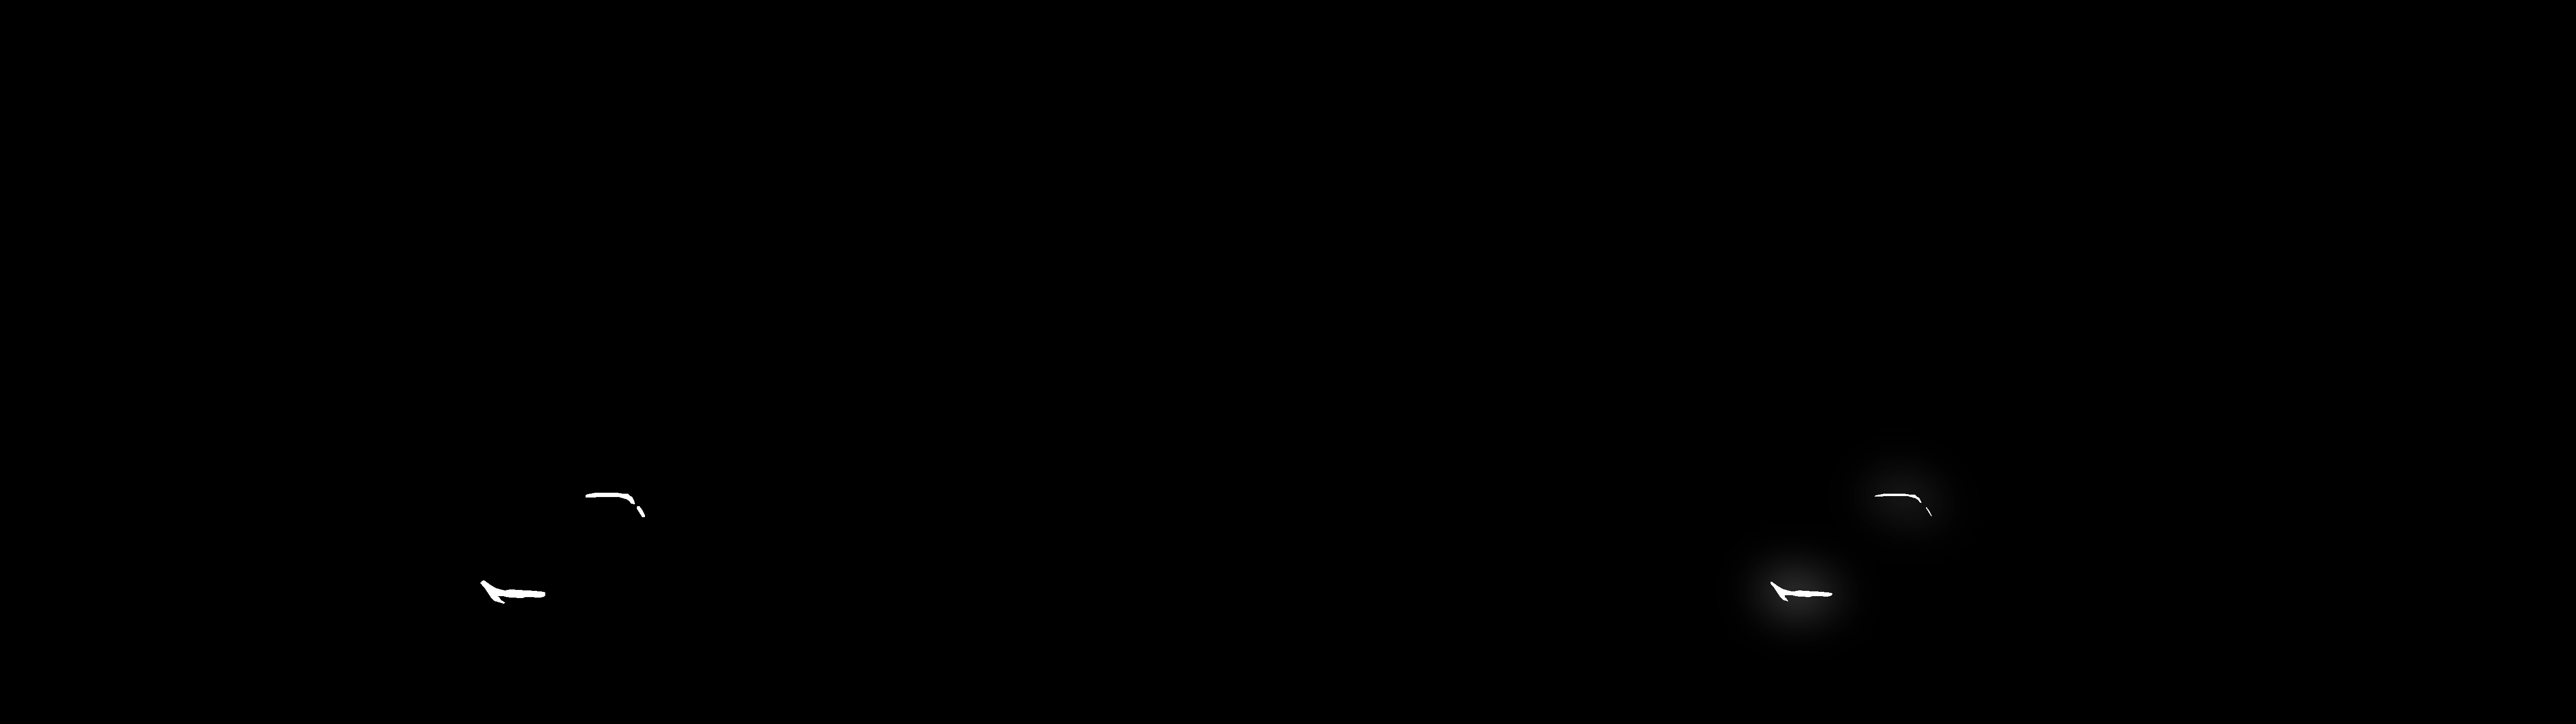

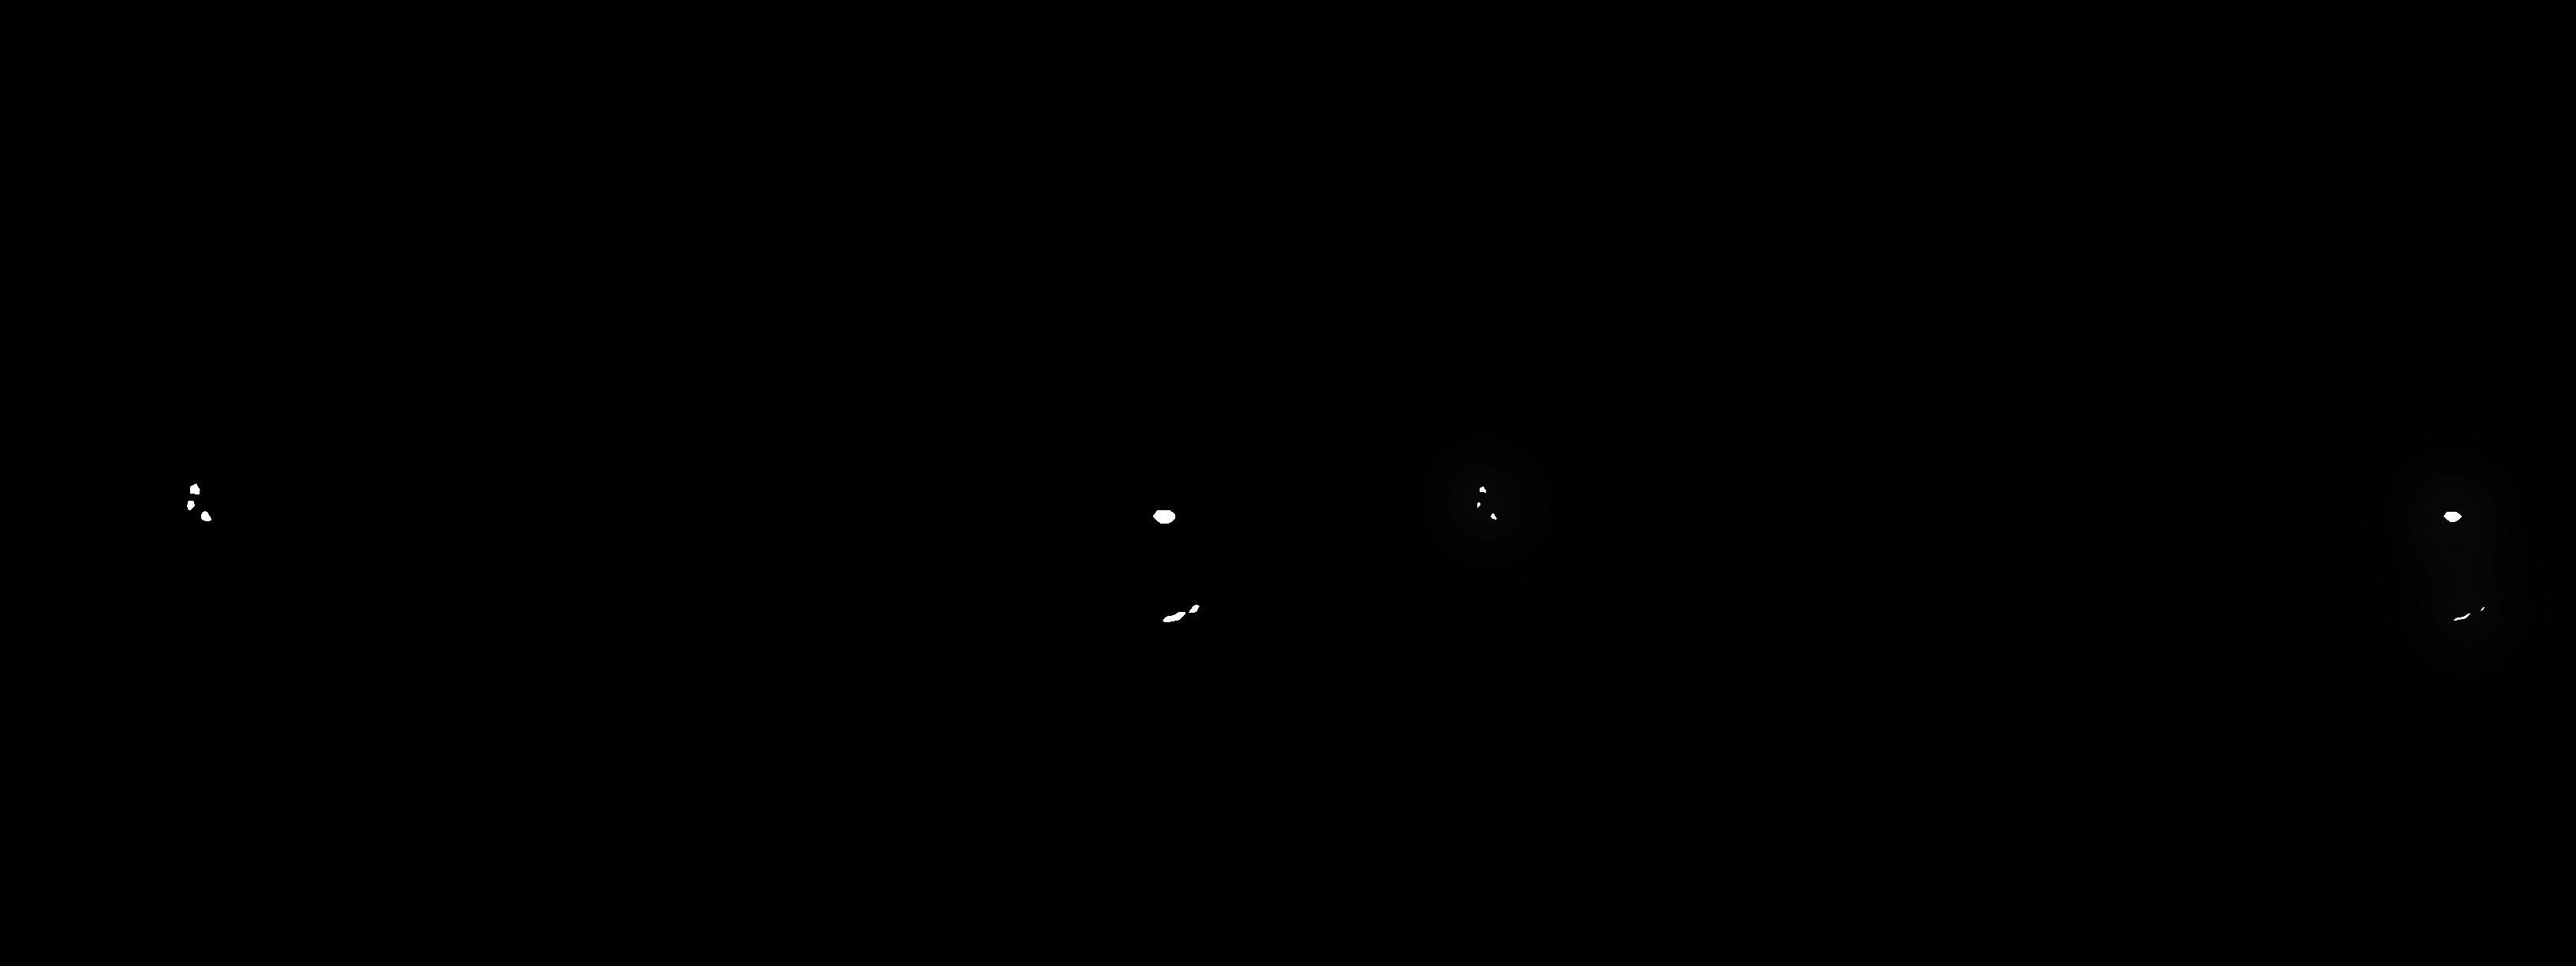

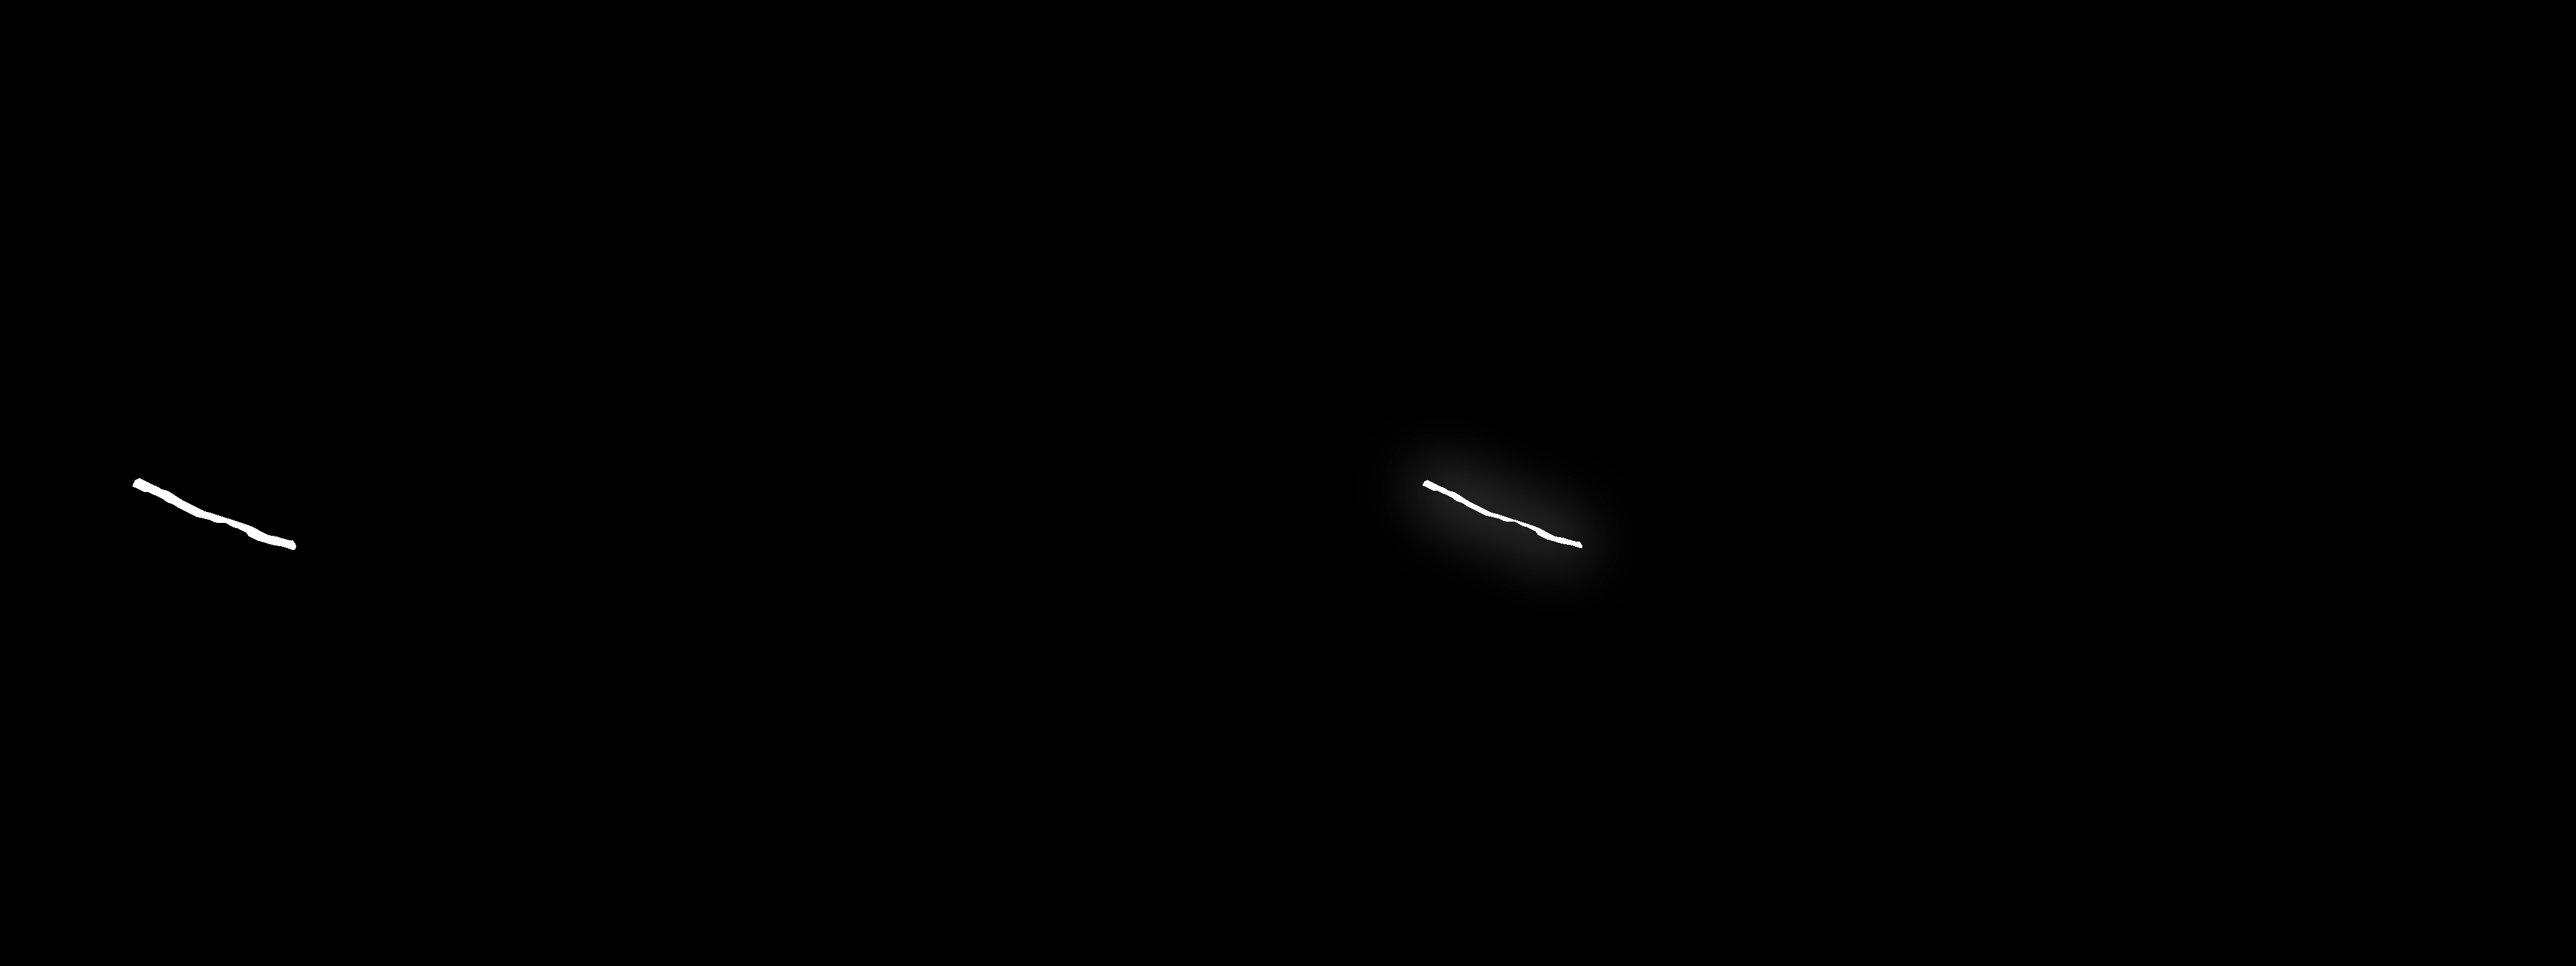

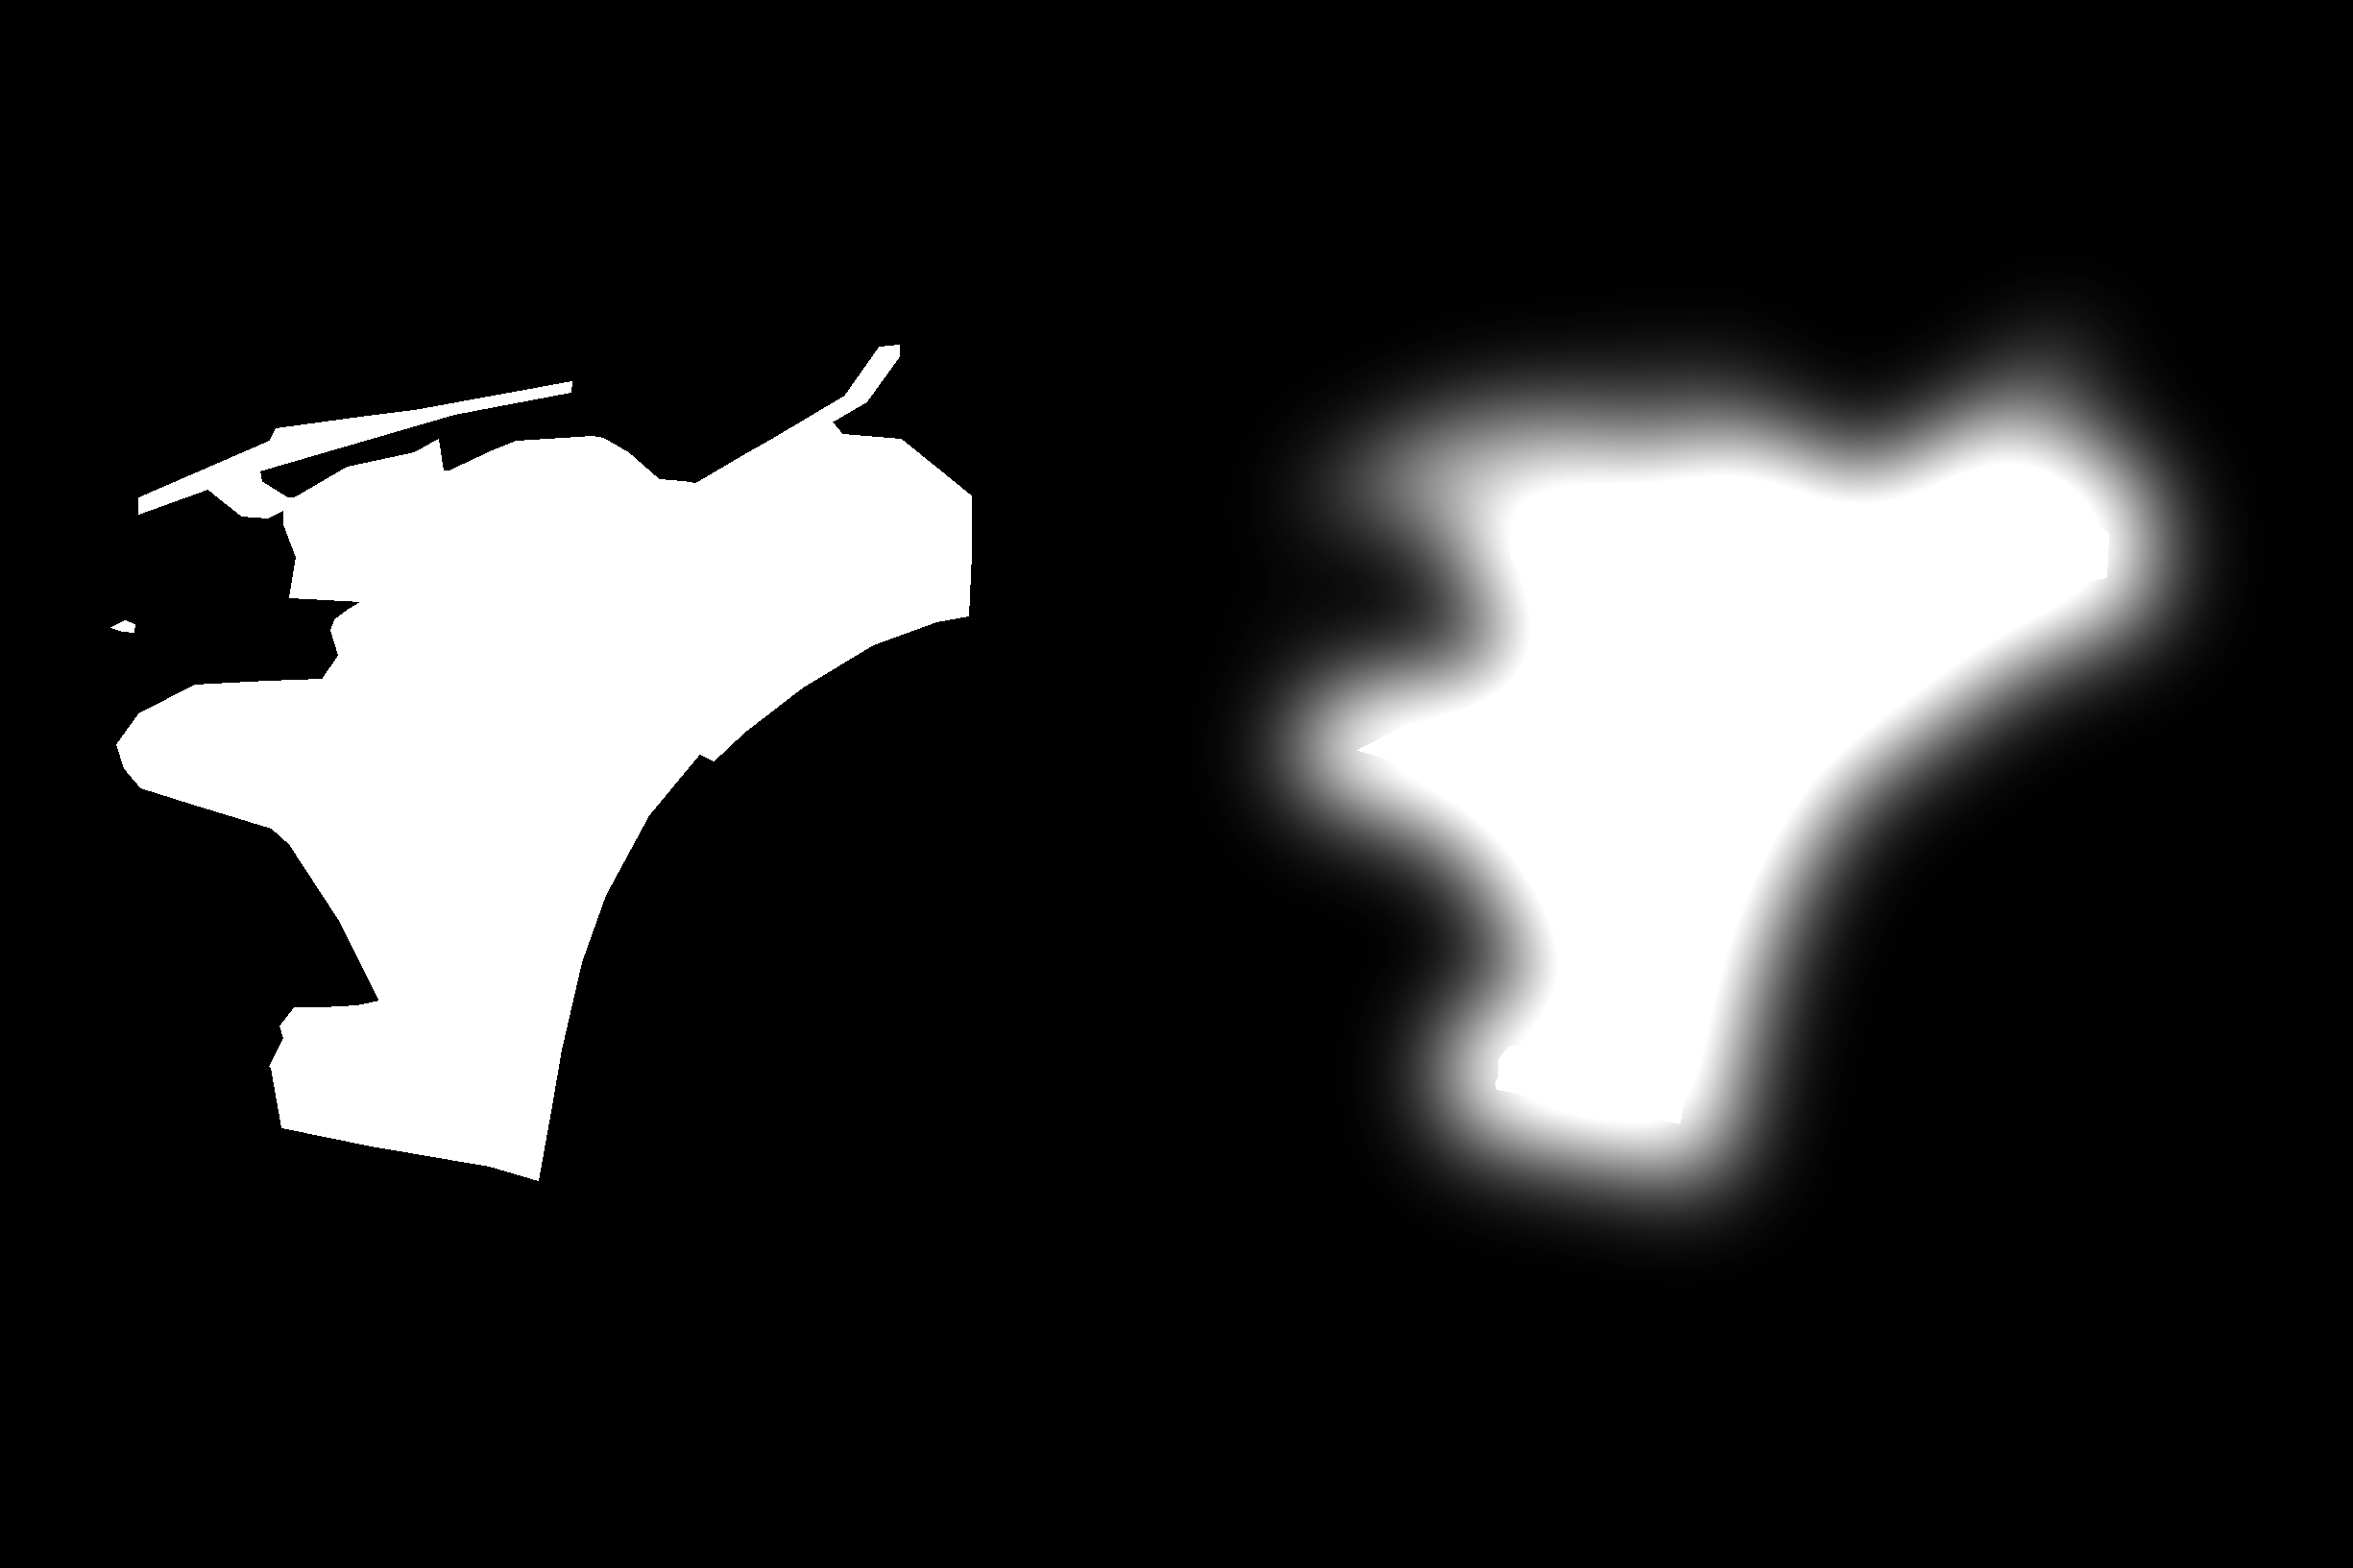

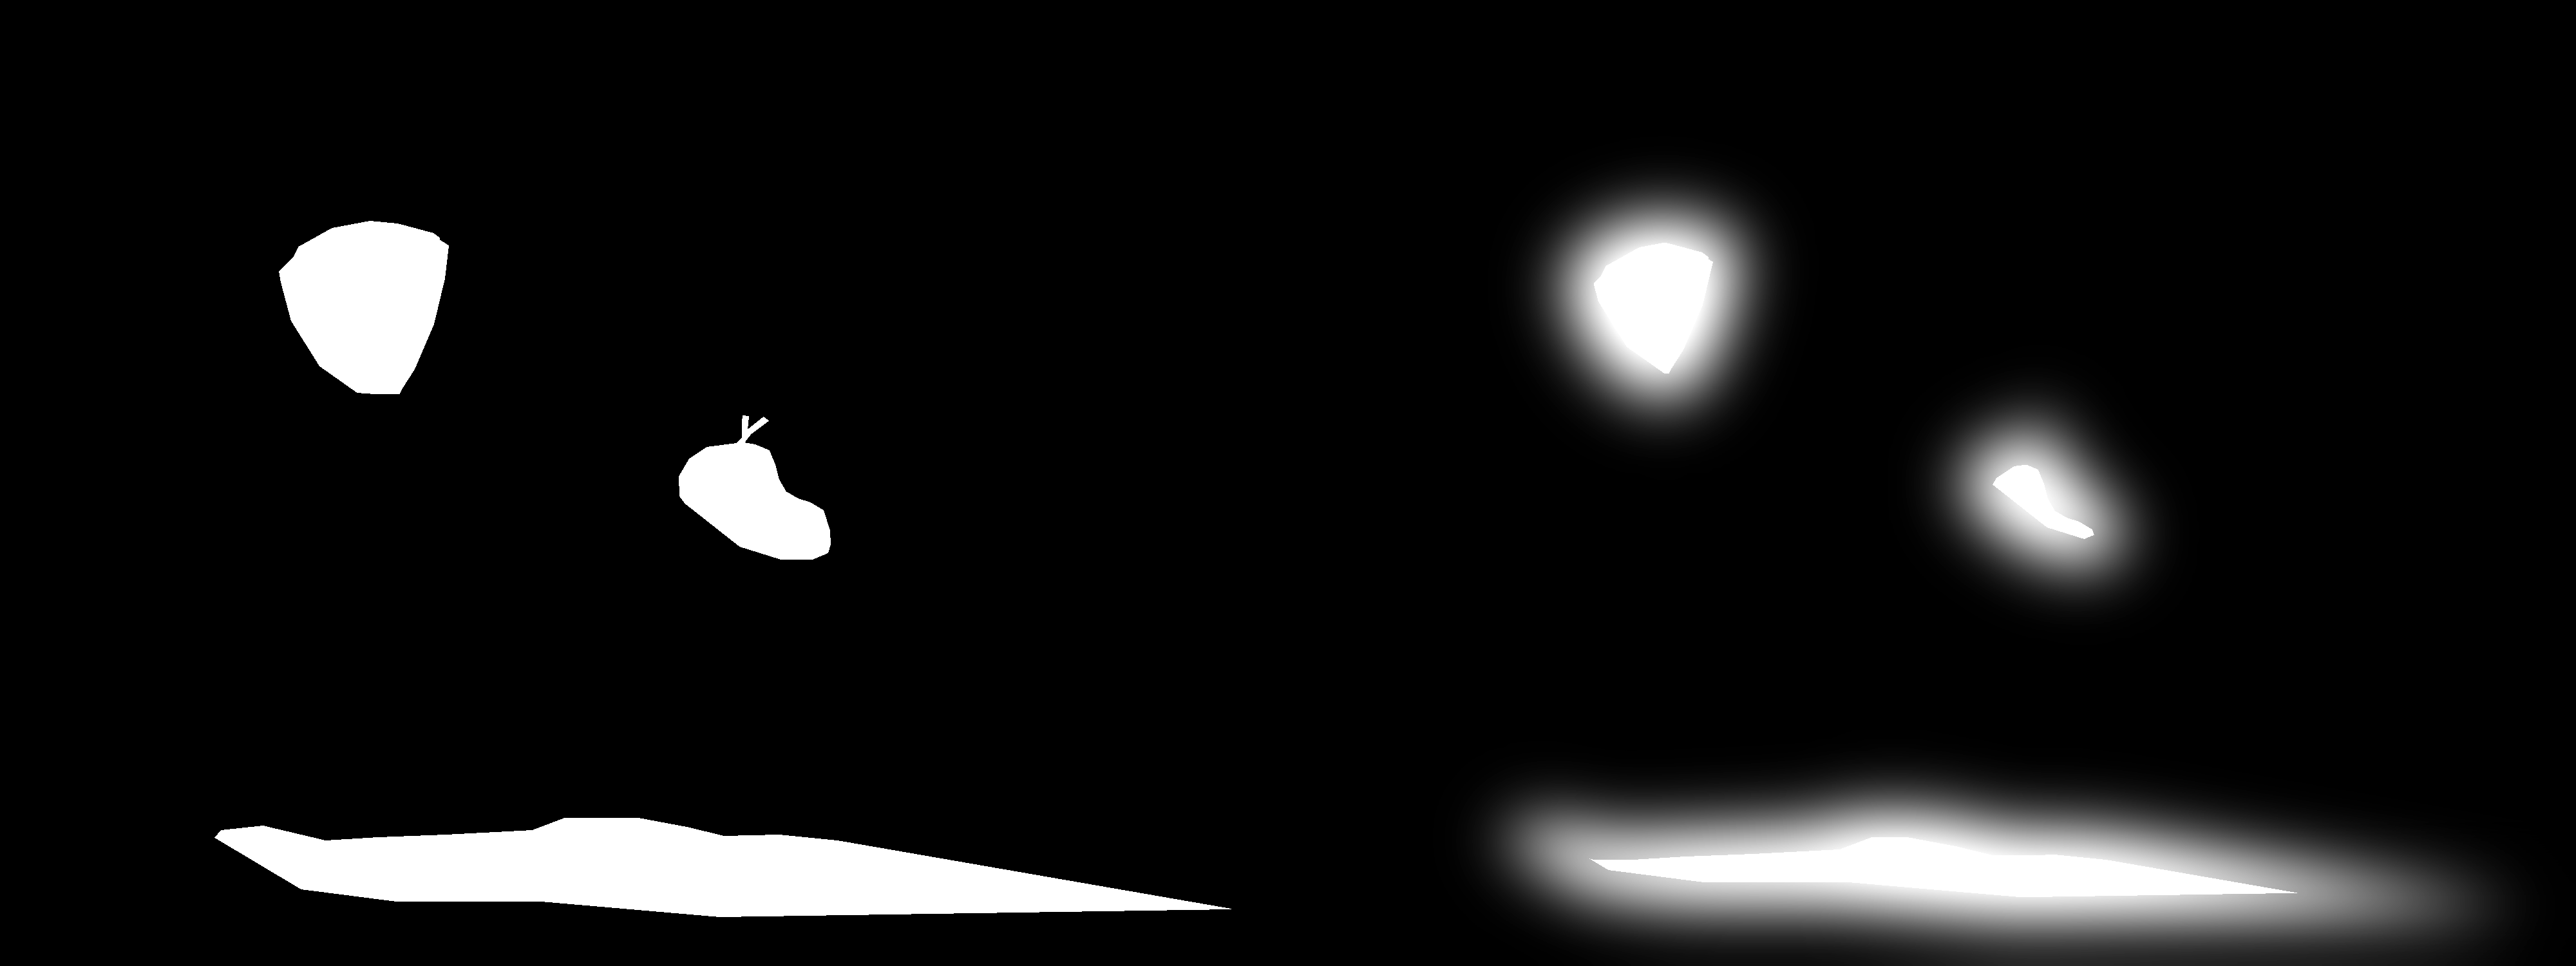

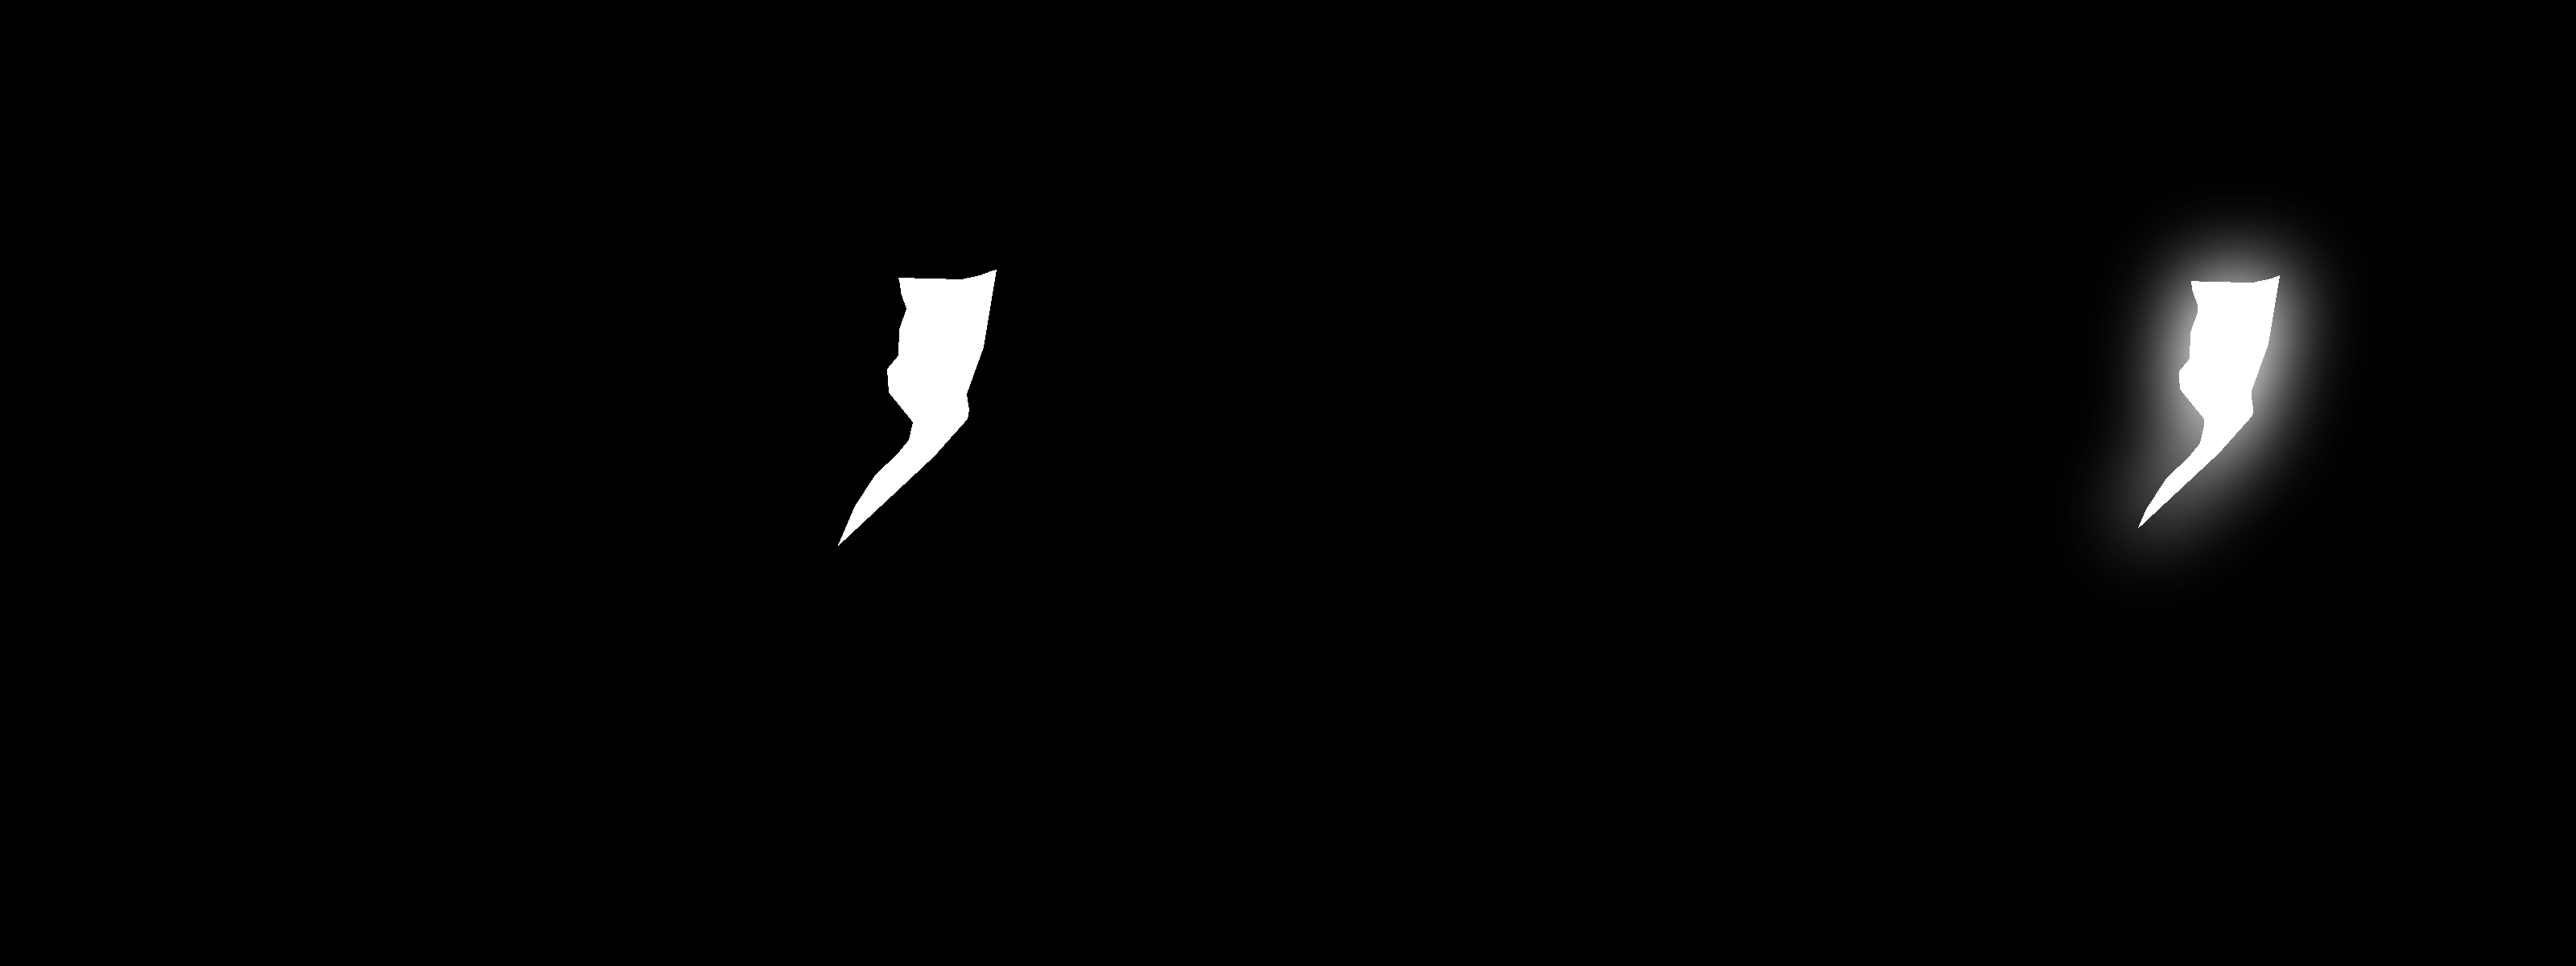

In [60]:
from  IPython.display import display

for mask in damage_masks[:20]:
    mask_edit = transform(mask)
    masks_concat = np.hstack((mask, mask_edit))

    display(Image.fromarray(masks_concat.astype('uint8')))

In [3]:
i = 0

In [ ]:
mask = damage_masks[i]
i += 1
mask[mask < 50] = 0
mask[mask >= 50] = 255
Image.fromarray(mask.astype('uint8'))

In [36]:
import sys
sys.path.append('/Users/user/Main/Repos/blender-scripting')
from importlib import reload
import renderlib
reload(renderlib)

graph = load_pkl('/Users/user/Downloads/11_front_left_door.pkl')
mesh_traverser = renderlib.mesh_traversal.MeshTraverser(graph, damage_matrix)

In [22]:
len(mesh_traverser.coord_mapping), len(damaged_polys)

(50777, 110)

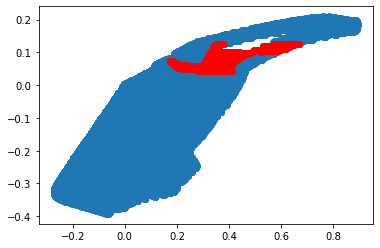

In [37]:
import matplotlib.pyplot as plt

coords_x = []
coords_y = []

for x, y in mesh_traverser.coord_mapping.values():
    coords_x.append(x)
    coords_y.append(y)

plt.scatter(coords_x, coords_y)

damaged_polys = mesh_traverser.get_masked_polys(np.zeros(2))

coords_x = []
coords_y = []

for poly_id in damaged_polys:
    x, y = mesh_traverser.coord_mapping[poly_id]
    coords_x.append(x)
    coords_y.append(y)

plt.scatter(coords_x, coords_y, color='red')

#custom_poly_ids = [380, 382, 384, 385, 392, 393, 394, 395, 551, 552, 553, 554, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 817, 822, 823, 824, 825, 826, 1057, 1059, 1062, 1063, 1064, 1065, 1066, 1067, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1092, 1103, 1752, 1753, 1756, 1757, 1758, 1759, 1760, 1767, 1926, 1927, 1928, 1929, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2190, 2198, 2199, 2200, 2201, 2202, 2430, 2431, 2437, 2438, 2439, 2440, 2441, 2442, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2464, 2465]
#
#for poly_id in custom_poly_ids:
#    plt.scatter(*mesh_traverser.coord_mapping[poly_id], color='red')

In [17]:
mesh_traverser.pca

In [12]:
list(mesh_traverser.coord_mapping.values())[0].dtype

dtype('float64')

In [6]:
import networkx as nx

edge_list = []

for poly_id, neighbour_ids in graph.poly_id_to_neighbour_poly_ids.items():
    for neighbour_id in neighbour_ids:
        edge_list.append([poly_id, neighbour_id])

G = nx.from_edgelist(edge_list)

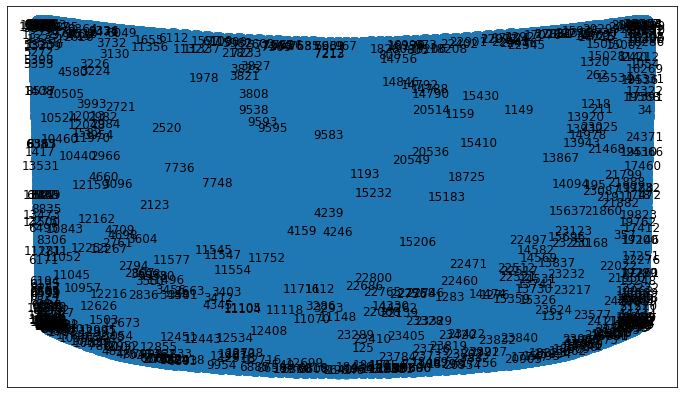

In [16]:
plt.figure(figsize=(12, 7))
pos = mesh_traverser.coord_mapping

labels_small = {k: k for k in pos if np.random.randint(50) == 1}
#nx.draw_networkx_labels(G, pos=pos);
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos, labels=labels_small);

In [52]:
from PIL import Image

masks = load_pkl('/Users/user/Downloads/damage_bboxes.pkl')

In [35]:
for mask in masks:
    print(mask.shape)

(1210, 1236)
(19, 128)
(13, 27)
(29, 47)
(23, 30)
(41, 77)
(22, 15)
(25, 56)
(39, 70)
(32, 105)
(25, 23)
(35, 90)
(89, 94)
(14, 14)
(917, 320)
(23, 117)
(15, 54)
(11, 24)
(37, 51)
(488, 690)
(50, 526)
(74, 96)
(63, 10)
(112, 389)
(102, 294)
(73, 57)
(38, 43)
(23, 31)
(209, 129)
(61, 114)
(145, 494)
(284, 541)
(60, 86)
(132, 454)
(108, 35)
(82, 188)
(11, 61)
(13, 51)
(22, 73)
(169, 72)
(140, 31)
(16, 26)
(133, 62)
(102, 54)
(35, 40)
(381, 206)
(62, 108)
(34, 76)
(121, 151)
(81, 40)
(388, 476)
(153, 341)
(28, 32)
(42, 105)
(80, 61)
(39, 107)
(95, 103)
(118, 145)
(51, 35)
(32, 102)
(346, 288)
(103, 233)
(41, 131)
(82, 70)
(32, 92)
(96, 70)
(36, 14)
(191, 101)
(23, 19)
(84, 160)
(132, 130)
(47, 42)
(59, 31)
(40, 60)
(414, 398)
(138, 342)
(46, 196)
(37, 33)
(81, 217)
(123, 92)
(47, 176)
(15, 17)
(15, 13)
(13, 9)
(13, 23)
(11, 15)
(49, 35)
(39, 82)
(33, 16)
(9, 15)
(157, 78)
(25, 47)
(39, 52)
(23, 40)
(28, 92)
(224, 229)
(22, 17)
(36, 24)
(30, 77)
(331, 180)
(149, 91)
(410, 361)
(94, 123)
(3

In [53]:
masks = [np.array(Image.fromarray(mask.astype('uint8')).resize((300, 200)))
         for mask in masks if mask.shape[0] > 150 and mask.shape[1] > 150]

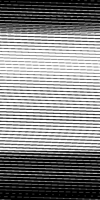

In [39]:
Image.fromarray(masks[1].astype('uint8')).resize((100, 200))

In [55]:
masks[0].shape

(200, 300)

In [58]:
dump_pkl(masks, '/Users/user/Downloads/damage_bboxes_filtered.pkl')

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

parts_adjacency_matrix = pd.read_excel('/Users/user/Downloads/solaris_adjacent_parts.xlsx', index_col=0)

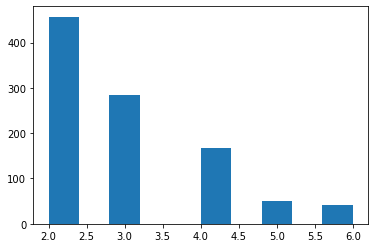

In [38]:


plt.hist([len(sample_damaged_parts(parts_adjacency_matrix)) for _ in range(1000)]);

In [36]:
sample_damaged_parts(parts_adjacency_matrix)

[4, 2, 37, 42]